In [1]:
%matplotlib inline

In [2]:
#import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
#from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc

from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.stats import spearmanr
import seaborn as sns

## Read the SLP Scores 

In [225]:
### LINUX BOX PATH
#path = r'/home/deniz/Code/ClinicalScoreProject/NeuroFace_Dataset/ALS/SLP_Assessment_ALS.csv'


# ALS DATA
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/ALS/SLP_Assessment_ALS.csv'
df_als = pd.read_csv(path)

df_als = df_als.drop('Unnamed: 8', axis=1)

#print(df_als.shape)
#print(df_als.columns)
#print(df_als['Subject ID'].unique())
#df_als.head()

# STROKE DATA
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Stroke/SLP_Assessment_PS.csv'
df_ps = pd.read_csv(path)

df_ps = df_ps.drop('Unnamed: 8', axis=1)

#print(df_ps.shape)
#print(df_ps.columns)
#print(df_ps['Subject ID'].unique())
#df_ps.head()

# HEALTHY CONTROL DATA
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Healthy controls/SLP_Assessment_HC.csv'
df_hc = pd.read_csv(path)

df_hc = df_hc.drop('Unnamed: 8', axis=1)
df_hc = df_hc.drop('Unnamed: 15', axis=1)
#print(df_hc.shape)
#print(df_hc.columns)
#print(df_hc['Subject ID'].unique())



slp_scores = pd.concat([df_als, df_ps, df_hc], ignore_index=True)
# average of the clinical scores 

slp_scores['Tot_avg'] = slp_scores.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
slp_scores['Symmetry_avg'] = slp_scores.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
slp_scores['ROM_avg'] = slp_scores.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
slp_scores['Speed_avg'] = slp_scores.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
slp_scores['Variability_avg'] = slp_scores.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
slp_scores['Fatigue_avg'] = slp_scores.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)


tasks = ['BBP_NORMAL',  'PATAKA', 'PA','BLOW', 'KISS', 'OPEN', 'SPREAD', 'BIGSMILE', 'BROW']

ids = ['A', 'O', 'S', 'N']

def task_labeler(row):
    for t in tasks: 
        if t in row: 
            return t
        
def pop_labeler(row):
    for i in ids:
        if i in row:
            if i == "A":
                return 'ALS'
            elif i == 'O' or i == "S":
                return 'Stroke'
            else:
                return 'HC'
    

slp_scores['task'] = [task_labeler(x) for x in slp_scores['File Name']]
slp_scores['population'] = [pop_labeler(x) for x in slp_scores['Subject ID']]

print(slp_scores.shape)
print(slp_scores.columns)
print()
print('Total numbr of participants are: ',len(slp_scores['Subject ID'].unique()))
print()
print('Subject IDs included are: ',slp_scores['Subject ID'].unique())
print()
print(slp_scores.columns)
print()
print('The tasks are: ', slp_scores['task'].unique())

slp_scores.head()



(261, 22)
Index(['File Name', 'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)',
       'Speed (SLP1)', 'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)',
       'Symmetry (SLP2)', 'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)',
       'Fatigue (SLP2)', 'Tot (SLP2)', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg', 'task', 'population'],
      dtype='object')

Total numbr of participants are:  36

Subject IDs included are:  ['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A016'
 'A017' 'OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007'
 'S008' 'S009' 'S011' 'S012' 'S013' 'N001' 'N002' 'N003' 'N004' 'N007'
 'N008' 'N010' 'N011' 'N012' 'N017' 'N019']

Index(['File Name', 'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)',
       'Speed (SLP1)', 'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)',
       'Symmetry (SLP2)', 'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)',
       'Fatigue (SLP2)', 'Tot (SLP2)', 'Tot_av

,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),...,Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task,population
0,A002_02_BBP_NORMAL_color.avi,A002,1,1,1,1,1,5,2,1,...,1,6,5.5,1.5,1.0,1.0,1.0,1.0,BBP_NORMAL,ALS
1,A002_02_DDK_PATAKA_color.avi,A002,1,1,1,1,1,5,2,2,...,2,9,7.0,1.5,1.5,1.0,1.5,1.5,PATAKA,ALS
2,A002_02_DDK_PA_color.avi,A002,1,1,1,1,1,5,2,2,...,2,9,7.0,1.5,1.5,1.0,1.5,1.5,PA,ALS
3,A002_02_NSM_BLOW_color.avi,A002,2,1,1,2,1,7,1,2,...,1,8,7.5,1.5,1.5,1.5,2.0,1.0,BLOW,ALS
4,A002_02_NSM_KISS_color.avi,A002,2,1,1,1,4,9,1,1,...,3,7,8.0,1.5,1.0,1.0,1.0,3.5,KISS,ALS


In [129]:

print(df_als['Subject ID'].unique())
print(len(df_als['Subject ID'].unique()))

print(df_ps['Subject ID'].unique())
print(len(df_ps['Subject ID'].unique()))

print(df_hc['Subject ID'].unique())
print(len(df_hc['Subject ID'].unique()))



['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A016'
 'A017']
11
['OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007' 'S008'
 'S009' 'S011' 'S012' 'S013']
14
['N001' 'N002' 'N003' 'N004' 'N007' 'N008' 'N010' 'N011' 'N012' 'N017'
 'N019']
11


In [132]:
a = slp_scores.groupby(['population', 'task']).count()

slp_scores.groupby(['population','task'])['Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg'].describe()


<ipython-input-132-cbf6efbffae7>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  slp_scores.groupby(['population','task'])['Tot_avg', 'Symmetry_avg', 'ROM_avg',


Tot_avg                                                  \
                        count       mean       std  min    25%    50%     75%   
population task                                                                 
ALS        BBP_NORMAL     9.0   7.611111  1.850300  5.5  6.000   7.00   9.000   
           BIGSMILE       4.0   9.125000  1.750000  7.0  8.125   9.25  10.250   
           BLOW           6.0   6.416667  0.801041  5.5  5.750   6.50   6.875   
           BROW           4.0   5.500000  0.408248  5.0  5.375   5.50   5.625   
           KISS          11.0   7.590909  2.467977  5.5  6.000   6.50   8.500   
           OPEN          11.0   6.363636  1.097518  5.0  5.500   6.50   7.000   
           PA            10.0   8.200000  1.960725  6.5  6.625   7.50   9.000   
           PATAKA        10.0   8.450000  1.423025  5.5  8.000   8.75   9.375   
           SPREAD        11.0   9.590909  3.104981  6.0  7.500   8.50  11.500   
HC         BBP_NORMAL    11.0   5.863636  0.595437  5.0  5.500   5.50   6.250   
           BIGSMILE       3.0   6.500000  1.500000  5.0  5.750   6.50   7.250   
           BLOW           7.0   5.785714  0.906327  5.0  5.000   6.00   6.000   
           BROW           4.0   5.625000  1.250000  5.0  5.000   5.00   5.625   
           KISS          11.0   5.772727  0.646670  5.0  5.500   5.50   6.250   
           OPEN          11.0   5.545455  0.522233  5.0  5.000   5.50   6.000   
           PA            11.0   5.590909  0.583874  5.0  5.000   5.50   6.000   
           PATAKA        11.0   5.863636  0.896965  5.0  5.000   5.50   6.500   
           SPREAD        11.0   6.772727  2.078024  5.0  5.000   6.00   8.500   
Stroke     BBP_NORMAL    14.0   9.107143  2.489814  5.0  7.500   9.00  10.500   
           BIGSMILE       3.0   6.333333  1.154701  5.0  6.000   7.00   7.000   
           BLOW          11.0   7.363636  2.025968  5.5  6.250   7.00   7.250   
           BROW           7.0   8.642857  3.543942  5.0  6.250   7.00  10.500   
           KISS          14.0   8.785714  2.599662  5.0  7.000   8.75   9.875   
           OPEN          14.0   6.892857  1.163195  5.0  6.500   6.50   7.375   
           PA            14.0   9.607143  2.482079  6.0  7.750   9.50  10.375   
           PATAKA        14.0   8.785714  2.100497  5.5  7.000   9.25  10.500   
           SPREAD        14.0  10.750000  2.585090  6.0  9.500  10.00  11.250   

                            Symmetry_avg            ... Variability_avg       \
                        max        count      mean  ...             75%  max   
population task                                     ...                        
ALS        BBP_NORMAL  11.0          9.0  1.833333  ...           1.500  2.0   
           BIGSMILE    11.0          4.0  2.125000  ...           2.250  3.0   
           BLOW         7.5          6.0  1.750000  ...           1.500  2.0   
           BROW         6.0          4.0  1.125000  ...           1.000  1.0   
           KISS        14.0         11.0  1.681818  ...           1.500  3.0   
           OPEN         8.5         11.0  1.590909  ...           1.500  2.0   
           PA          12.5         10.0  1.900000  ...           1.875  3.0   
           PATAKA      10.5         10.0  1.850000  ...           1.500  3.0   
           SPREAD      15.0         11.0  1.772727  ...           3.000  3.5   
HC         BBP_NORMAL   7.0         11.0  1.318182  ...           1.000  1.5   
           BIGSMILE     8.0          3.0  1.500000  ...           1.250  1.5   
           BLOW         7.5          7.0  1.357143  ...           1.250  2.0   
           BROW         7.5          4.0  1.125000  ...           1.125  1.5   
           KISS         7.0         11.0  1.272727  ...           1.500  1.5   
           OPEN         6.5         11.0  1.454545  ...           1.000  1.5   
           PA           6.5         11.0  1.227273  ...           1.000  2.0   
           PATAKA       7.5         11.0  1.363636  ...           1.250

In [117]:
slp_scores.groupby(['population']).count()

,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),...,Variability (SLP2),Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task
population,,,,,,,,,,,,,,,,,,,,,
ALS,76,76,76,76,76,76,76,76,76,76,...,76,76,76,76,76,76,76,76,76,76
HC,80,80,80,80,80,80,80,80,80,80,...,80,80,80,80,80,80,80,80,80,80
Stroke,105,105,105,105,105,105,105,105,105,105,...,105,105,105,105,105,105,105,105,105,105


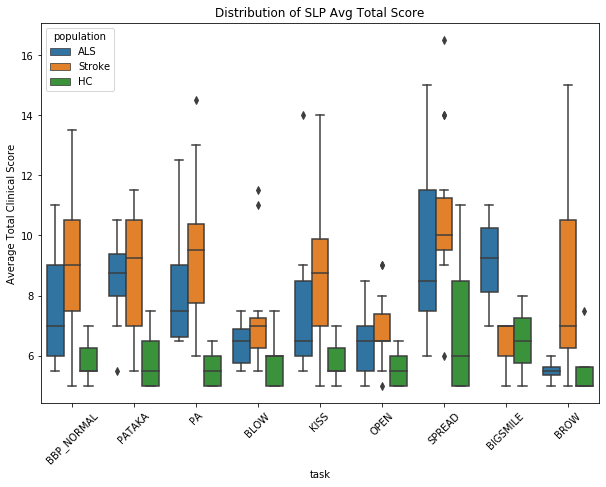

In [141]:
# Clinical Scores
ax, figure = plt.subplots(figsize=(10,7))
g = sns.boxplot(x='task', y='Tot_avg',data=slp_scores, hue='population')
plt.title('Distribution of SLP Total Score')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.ylabel('Average Total Clinical Score')
plt.title('Distribution of SLP Avg Total Score')

plt.show()

if 0:
    sns.boxplot(x=df['Subject ID'], y=df['Tot (SLP2)'])
    plt.title('Distribution of SLP2 Total Score')
    plt.show()

    sns.boxplot(x=df['Subject ID'], y=df['Tot_avg'])
    plt.title('Distribution of SLP Avg Total Score')
    plt.show()

In [226]:
neuroface_subjects = slp_scores['Subject ID'].unique()
neuroface_subjects

array(['A002', 'A006', 'A008', 'A009', 'A010', 'A011', 'A012', 'A014',
       'A015', 'A016', 'A017', 'OP01', 'OP02', 'OP03', 'S001', 'S002',
       'S003', 'S005', 'S006', 'S007', 'S008', 'S009', 'S011', 'S012',
       'S013', 'N001', 'N002', 'N003', 'N004', 'N007', 'N008', 'N010',
       'N011', 'N012', 'N017', 'N019'], dtype=object)

In [229]:
def hc_label_change(sub_id):
    s = sub_id
    if 'N' in sub_id: 
        
        s = s.replace('N0', 'NF')

    return s



In [230]:
slp_scores['Subject ID'] = [hc_label_change(x) for x in slp_scores['Subject ID']]

In [231]:
slp_scores['Subject ID'].unique()

array(['A002', 'A006', 'A008', 'A009', 'A010', 'A011', 'A012', 'A014',
       'A015', 'A016', 'A017', 'OP01', 'OP02', 'OP03', 'S001', 'S002',
       'S003', 'S005', 'S006', 'S007', 'S008', 'S009', 'S011', 'S012',
       'S013', 'NF01', 'NF02', 'NF03', 'NF04', 'NF07', 'NF08', 'NF10',
       'NF11', 'NF12', 'NF17', 'NF19'], dtype=object)

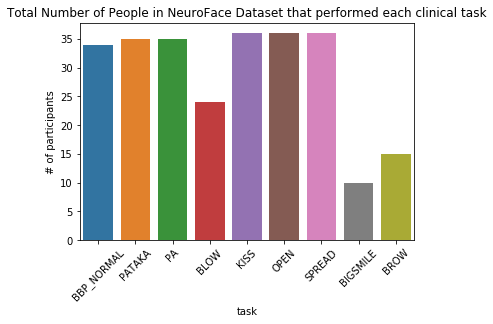

In [50]:
# TASKS 

g = sns.countplot(x='task',data=slp_scores)
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# set axes labels and title
plt.ylabel('# of participants')
plt.title('Total Number of People in NeuroFace Dataset that performed each clinical task')
plt.show()

//anaconda3/envs/csc2541/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


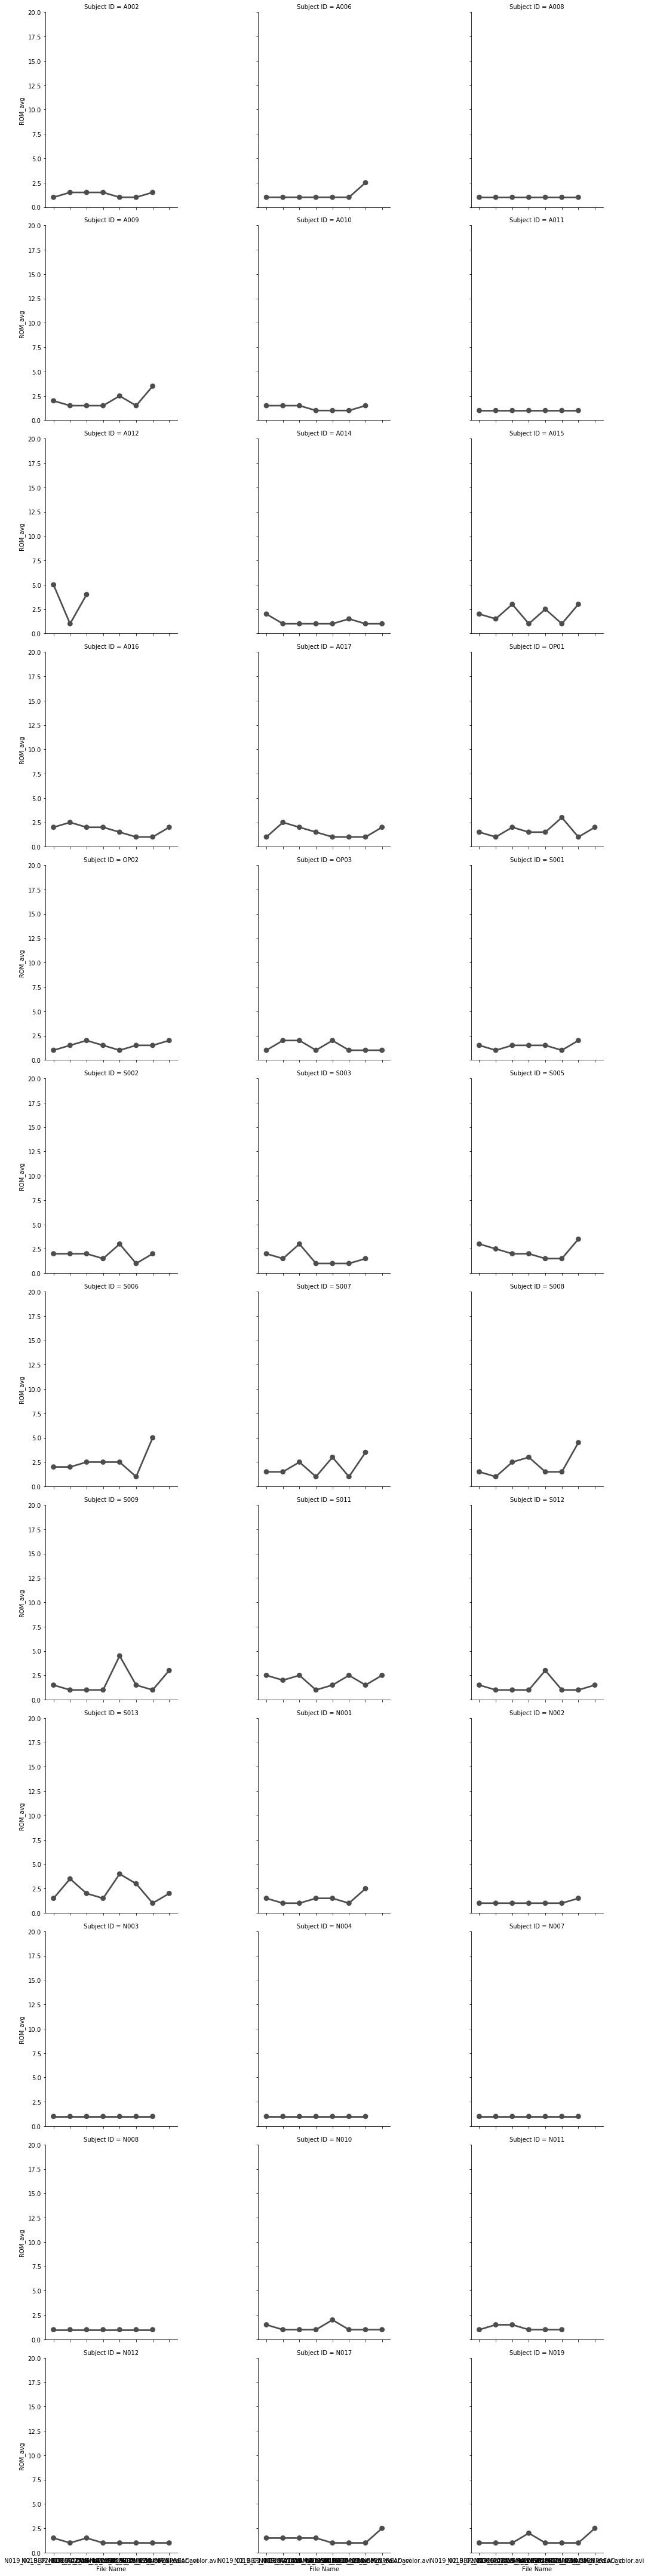

In [6]:
g = sns.FacetGrid(slp_scores, col="Subject ID", col_wrap=3, height=5, ylim=(0, 20))
g.map(sns.pointplot, "File Name", "ROM_avg",color=".3", ci=None);


//anaconda3/envs/csc2541/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


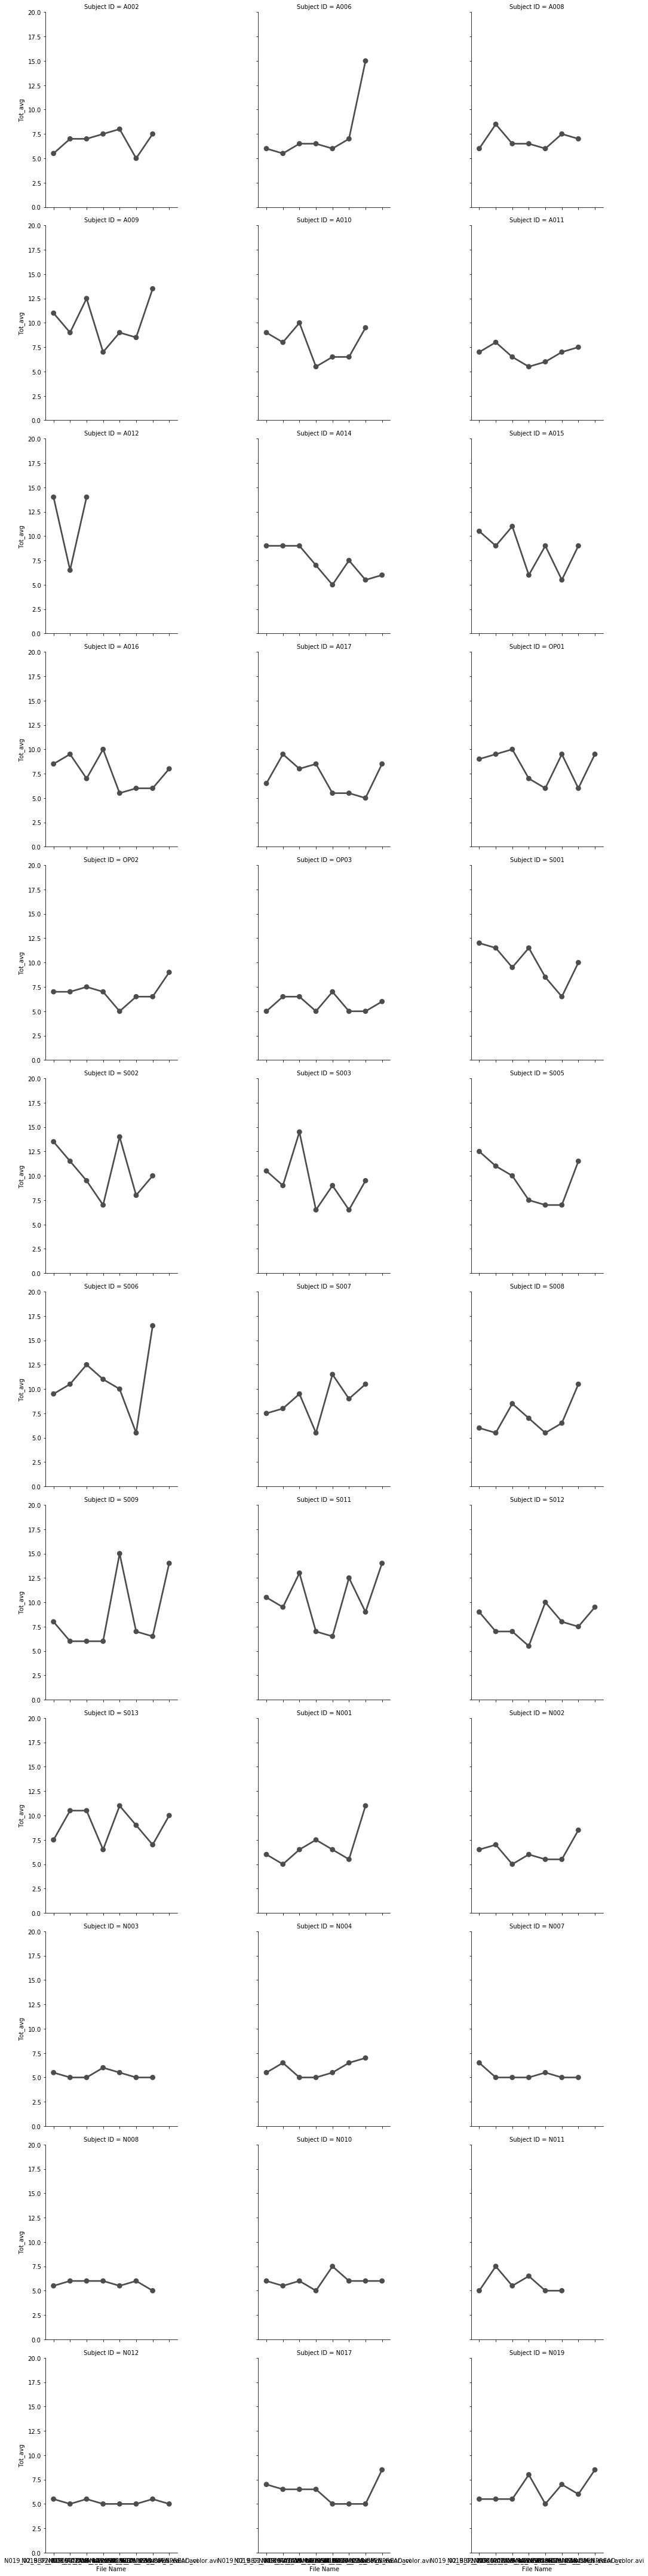

In [7]:
g = sns.FacetGrid(slp_scores, col="Subject ID", col_wrap=3, height=5, ylim=(0, 20))
g.map(sns.pointplot, "File Name", "Tot_avg",color=".3", ci=None);


In [8]:

path2 = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/ALS/VID_DATASET_Clinical information_ALS.csv'
als_df_demog = pd.read_csv(path2)

print(len(als_df_demog))
print(als_df_demog.columns)
print(als_df_demog.SubjectID.unique())
als_df_demog.head()

10
Index(['SubjectID', 'AgeSession', 'Gender', 'DisDurDiag', 'AgeDiag',
       'DisDurON', 'AgeOnset', 'SiteOnset', 'ALSFRSTot', 'ALSFRSBulb',
       'Intell (%)', 'SpeakRate (words/min)'],
      dtype='object')
['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A017']


,SubjectID,AgeSession,Gender,DisDurDiag,AgeDiag,DisDurON,AgeOnset,SiteOnset,ALSFRSTot,ALSFRSBulb,Intell (%),SpeakRate (words/min)
0,A002,62,F,19,60,31,59,Lower limbs,31,12,100,151.72
1,A006,64,F,20,62,109,55,Upper/Lower limbs,26,12,96.36,122.68
2,A008,55,M,15,54,28,53,Upper limbs,39,11,91.82,143.17
3,A009,45,F,29,42,41,41,Lower limbs,26,7,28.18,63.28
4,A010,68,M,10,67,26,66,Upper limbs,40,12,87.27,88.61


# Fine-Tuned Diego's Results 

In [71]:
def print_prop(df, file):
    print(file)
    print('Shape: ',df.shape)
    print()
    print(df.columns)
    print()
    print('Total Number of Subjects in Df are: ', len(df.subject_id.unique()))
    print("Subjects IDs are: ",df.subject_id.unique())
    print()



### Diego Stroke DATA 

In [154]:
### STROKE DATA

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0# 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE

stroke_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_"+tasks[task]+".csv"
stroke_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
stroke_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
stroke_file_4 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"


bbp_s_df_1 = pd.read_csv(stroke_file_1)
bbp_s_df_1 = bbp_s_df_1.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_1, stroke_file_1)



bbp_s_df_2 = pd.read_csv(stroke_file_2)
bbp_s_df_2 = bbp_s_df_2.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_2, stroke_file_2)



bbp_s_df_3 = pd.read_csv(stroke_file_3)
bbp_s_df_3 = bbp_s_df_3.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_3, stroke_file_3)



bbp_s_df_4 = pd.read_csv(stroke_file_4)
bbp_s_df_4 = bbp_s_df_4.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_4, stroke_file_4)

/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_BBP_NORMAL.csv
Shape:  (457, 18)

Index(['subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
       'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3'],
      dtype='object')

Total Number of Subjects in Df are:  45
Subjects IDs are:  ['NF11' 'NF12' 'NF13' 'NF14' 'NF15' 'NF16' 'NF17' 'NF18' 'NF19' 'NF20'
 'NF21' 'NF22' 'NF24' 'NF26' 'NF27' 'NF00' 'NF02' 'NF03' 'NF04' 'NF05'
 'NF06' 'NF07' 'NF08' 'NF09' 'NF10' 'OP01' 'OP02' 'OP03' 'OP05' 'OP06'
 'OP07' 'OP08' 'OP09' 'OP10' 'OP12' 'S001' 'S002' 'S003' 'S005' 'S006'
 'S007' 'S008' 'S009' 'S010' 'S013']

/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_BBP_NORMAL.csv
Shape:  (220, 18)

Index(['subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX

In [158]:
bbp_s_df_1.head()

,subject_id,task,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,W_MIN,W_MAX_VEL,W_MIN_VEL,A_MOUTH,R_LCRC,D_0,D_1,D_2,D_3
0,NF11,BBP_NORMAL,0,1,2.286921,1.022002,0.594900,-0.544603,1.077094,0.876171,0.119329,-0.104292,2.098207,0.215262,0.975132,1.049206,0.568557,1.173047
1,NF11,BBP_NORMAL,0,2,2.188607,0.996711,0.820745,-0.436266,1.044838,0.870372,0.095685,-0.054182,1.825080,0.091104,1.491866,0.899794,0.533262,1.128183
2,NF11,BBP_NORMAL,0,3,2.058023,1.047133,0.769061,-0.903222,1.022509,0.865620,0.047249,-0.049228,1.695076,0.367979,1.359297,0.993397,0.818813,1.007924
3,NF11,BBP_NORMAL,0,4,2.075979,1.042164,1.059445,-0.647830,1.027606,0.885372,0.059202,-0.064426,2.170755,0.170831,0.910991,0.902072,0.835538,1.109912
4,NF11,BBP_NORMAL,0,5,1.981968,1.005337,0.676766,-0.322046,1.134544,0.922301,0.114083,-0.139226,2.475245,0.445453,1.032537,1.729688,0.614693,0.953813


In [155]:
print('1 includes 2: ', set(bbp_s_df_2.subject_id.unique()).issubset(bbp_s_df_1.subject_id.unique()))
print('1 includes 3: ', set(bbp_s_df_3.subject_id.unique()).issubset(bbp_s_df_1.subject_id.unique()))
print('1 includes 4: ', set(bbp_s_df_4.subject_id.unique()).issubset(bbp_s_df_1.subject_id.unique()))

1 includes 2:  True
1 includes 3:  True
1 includes 4:  True


In [164]:
for task in range(len(tasks)):
    
    stroke_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_"+tasks[task]+".csv"
    stroke_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
    stroke_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
    stroke_file_4 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"


    print(tasks[task])
    try: 
        df_1 = pd.read_csv(stroke_file_1)
        #df_1 = df_1.drop('Unnamed: 0', axis=1)
        print("df1 shape: ", df_1.shape)
        df_2 = pd.read_csv(stroke_file_2)
        #df_2 = df_2.drop('Unnamed: 0', axis=1)
        print("df2 shape: ", df_2.shape)
        df_3 = pd.read_csv(stroke_file_3)
        #df_3 = df_3.drop('Unnamed: 0', axis=1)
        print("df3 shape: ", df_3.shape)
        df_4 = pd.read_csv(stroke_file_4)
        print("df4 shape: ", df_4.shape)
        #df_4 = df_4.drop('Unnamed: 0', axis=1)
        
    except: 
        pass

    print('1 includes 2: ', set(df_2.subject_id.unique()).issubset(df_1.subject_id.unique()))
    print('1 includes 3: ', set(df_3.subject_id.unique()).issubset(df_1.subject_id.unique()))
    print('1 includes 4: ', set(df_4.subject_id.unique()).issubset(df_1.subject_id.unique()))


BBP_NORMAL
df1 shape:  (457, 19)
df2 shape:  (220, 19)
df3 shape:  (257, 19)
df4 shape:  (200, 19)
1 includes 2:  True
1 includes 3:  True
1 includes 4:  True
NSM_OPEN
df1 shape:  (229, 19)
df2 shape:  (113, 19)
df3 shape:  (126, 19)
df4 shape:  (103, 19)
1 includes 2:  True
1 includes 3:  True
1 includes 4:  True
NSM_SPREAD
df1 shape:  (231, 19)
df2 shape:  (120, 19)
df3 shape:  (123, 19)
df4 shape:  (108, 19)
1 includes 2:  True
1 includes 3:  True
1 includes 4:  True
NSM_BIGSMILE
df1 shape:  (118, 19)
df2 shape:  (30, 19)
df3 shape:  (118, 19)
1 includes 2:  True
1 includes 3:  True
1 includes 4:  False


In [162]:
stroke_df = pd.DataFrame()

for task in range(len(tasks)):
    
    stroke_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_"+tasks[task]+".csv"
    
    df = pd.read_csv(stroke_file)
    df = df.drop('Unnamed: 0', axis=1)
    stroke_df = pd.concat([stroke_df, df], ignore_index=True)

    
    
print(stroke_df.shape)



(1035, 18)


,subject_id,task,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,W_MIN,W_MAX_VEL,W_MIN_VEL,A_MOUTH,R_LCRC,D_0,D_1,D_2,D_3
0,NF11,BBP_NORMAL,0,1,2.286921,1.022002,0.594900,-0.544603,1.077094,0.876171,0.119329,-0.104292,2.098207,0.215262,0.975132,1.049206,0.568557,1.173047
1,NF11,BBP_NORMAL,0,2,2.188607,0.996711,0.820745,-0.436266,1.044838,0.870372,0.095685,-0.054182,1.825080,0.091104,1.491866,0.899794,0.533262,1.128183
2,NF11,BBP_NORMAL,0,3,2.058023,1.047133,0.769061,-0.903222,1.022509,0.865620,0.047249,-0.049228,1.695076,0.367979,1.359297,0.993397,0.818813,1.007924
3,NF11,BBP_NORMAL,0,4,2.075979,1.042164,1.059445,-0.647830,1.027606,0.885372,0.059202,-0.064426,2.170755,0.170831,0.910991,0.902072,0.835538,1.109912
4,NF11,BBP_NORMAL,0,5,1.981968,1.005337,0.676766,-0.322046,1.134544,0.922301,0.114083,-0.139226,2.475245,0.445453,1.032537,1.729688,0.614693,0.953813


In [170]:
stroke_df['population'] = [pop_labeler(x) for x in stroke_df['subject_id']]
stroke_df.head()

,subject_id,task,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,W_MIN,W_MAX_VEL,W_MIN_VEL,A_MOUTH,R_LCRC,D_0,D_1,D_2,D_3,population
0,NF11,BBP_NORMAL,0,1,2.286921,1.022002,0.594900,-0.544603,1.077094,0.876171,0.119329,-0.104292,2.098207,0.215262,0.975132,1.049206,0.568557,1.173047,HC
1,NF11,BBP_NORMAL,0,2,2.188607,0.996711,0.820745,-0.436266,1.044838,0.870372,0.095685,-0.054182,1.825080,0.091104,1.491866,0.899794,0.533262,1.128183,HC
2,NF11,BBP_NORMAL,0,3,2.058023,1.047133,0.769061,-0.903222,1.022509,0.865620,0.047249,-0.049228,1.695076,0.367979,1.359297,0.993397,0.818813,1.007924,HC
3,NF11,BBP_NORMAL,0,4,2.075979,1.042164,1.059445,-0.647830,1.027606,0.885372,0.059202,-0.064426,2.170755,0.170831,0.910991,0.902072,0.835538,1.109912,HC
4,NF11,BBP_NORMAL,0,5,1.981968,1.005337,0.676766,-0.322046,1.134544,0.922301,0.114083,-0.139226,2.475245,0.445453,1.032537,1.729688,0.614693,0.953813,HC


In [171]:

print('len: ' , len(stroke_df))
print(len(stroke_df.columns))
print(stroke_df.columns)
print(stroke_df.groupby(['population']).subject_id.unique())
print(stroke_df.task.unique())

len:  1035
19
Index(['subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
       'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3', 'population'],
      dtype='object')
population
HC        [NF11, NF12, NF13, NF14, NF15, NF16, NF17, NF1...
Stroke    [OP01, OP02, OP03, OP05, OP06, OP07, OP08, OP0...
Name: subject_id, dtype: object
['BBP_NORMAL' 'NSM_OPEN' 'NSM_SPREAD' 'NSM_BIGSMILE']


In [173]:
with np.printoptions(threshold=np.inf):
    print(stroke_df.groupby(['population']).subject_id.unique())

population
HC        [NF11, NF12, NF13, NF14, NF15, NF16, NF17, NF1...
Stroke    [OP01, OP02, OP03, OP05, OP06, OP07, OP08, OP0...
Name: subject_id, dtype: object


In [179]:
len(stroke_df.groupby(['population']).subject_id.unique()['Stroke'])

20

In [204]:
stroke_df.groupby(['population','task']).count()

subject_id  type  rep  O_MAX  O_MIN  O_MAX_VEL  \
population task                                                           
HC         BBP_NORMAL           258   258  258    258    258        258   
           NSM_BIGSMILE          67    67   67     67     67         67   
           NSM_OPEN             125   125  125    125    125        125   
           NSM_SPREAD           130   130  130    130    130        130   
Stroke     BBP_NORMAL           199   199  199    199    199        199   
           NSM_BIGSMILE          51    51   51     51     51         51   
           NSM_OPEN             104   104  104    104    104        104   
           NSM_SPREAD           101   101  101    101    101        101   

                         O_MIN_VEL  W_MAX  W_MIN  W_MAX_VEL  W_MIN_VEL  \
population task                                                          
HC         BBP_NORMAL          258    258    258        258        258   
           NSM_BIGSMILE         67     67     67         67         67   
           NSM_OPEN            125    125    125        125        125   
           NSM_SPREAD          130    130    130        130        130   
Stroke     BBP_NORMAL          199    199    199        199        199   
           NSM_BIGSMILE         51     51     51         51         51   
           NSM_OPEN            104    104    104        104        104   
           NSM_SPREAD          101    101    101        101        101   

                         A_MOUTH  R_LCRC  D_0  D_1  D_2  D_3  
population task                                               
HC         BBP_NORMAL        258     258  258  258  258  258  
           NSM_BIGSMILE       67      67   67   67   67   67  
           NSM_OPEN          125     125  125  125  125  125  
           NSM_SPREAD        130     130  130  130  130  130  
Stroke     BBP_NORMAL        199     199  199  199  199  199  
           NSM_BIGSMILE       51      51   51   51   51   51  
           NSM_OPEN          104     104  104  104  104  104  
           NSM_SPREAD        101     101  101  101  101  101

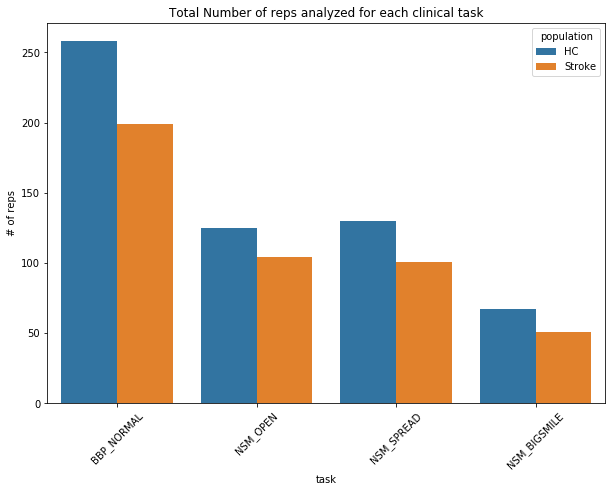

In [206]:
# TASKS 
ax, figure = plt.subplots(figsize=(10,7))
g = sns.countplot(x='task',data=stroke_df,hue='population')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# set axes labels and title
plt.ylabel('# of reps')
plt.title('Total Number of reps analyzed for each clinical task')
plt.show()

# Getting the corrolations based on the common data with clinical scores 

In [238]:
slp_scores.head()

,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),...,Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task,population
0,A002_02_BBP_NORMAL_color.avi,A002,1,1,1,1,1,5,2,1,...,1,6,5.5,1.5,1.0,1.0,1.0,1.0,BBP_NORMAL,ALS
1,A002_02_DDK_PATAKA_color.avi,A002,1,1,1,1,1,5,2,2,...,2,9,7.0,1.5,1.5,1.0,1.5,1.5,PATAKA,ALS
2,A002_02_DDK_PA_color.avi,A002,1,1,1,1,1,5,2,2,...,2,9,7.0,1.5,1.5,1.0,1.5,1.5,PA,ALS
3,A002_02_NSM_BLOW_color.avi,A002,2,1,1,2,1,7,1,2,...,1,8,7.5,1.5,1.5,1.5,2.0,1.0,BLOW,ALS
4,A002_02_NSM_KISS_color.avi,A002,2,1,1,1,4,9,1,1,...,3,7,8.0,1.5,1.0,1.0,1.0,3.5,KISS,ALS


In [240]:
stroke_df

,subject_id,task,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,W_MIN,W_MAX_VEL,W_MIN_VEL,A_MOUTH,R_LCRC,D_0,D_1,D_2,D_3,population
0,NF11,BBP_NORMAL,0,1,2.286921,1.022002,0.594900,-0.544603,1.077094,0.876171,0.119329,-0.104292,2.098207,0.215262,0.975132,1.049206,0.568557,1.173047,HC
1,NF11,BBP_NORMAL,0,2,2.188607,0.996711,0.820745,-0.436266,1.044838,0.870372,0.095685,-0.054182,1.825080,0.091104,1.491866,0.899794,0.533262,1.128183,HC
2,NF11,BBP_NORMAL,0,3,2.058023,1.047133,0.769061,-0.903222,1.022509,0.865620,0.047249,-0.049228,1.695076,0.367979,1.359297,0.993397,0.818813,1.007924,HC
3,NF11,BBP_NORMAL,0,4,2.075979,1.042164,1.059445,-0.647830,1.027606,0.885372,0.059202,-0.064426,2.170755,0.170831,0.910991,0.902072,0.835538,1.109912,HC
4,NF11,BBP_NORMAL,0,5,1.981968,1.005337,0.676766,-0.322046,1.134544,0.922301,0.114083,-0.139226,2.475245,0.445453,1.032537,1.729688,0.614693,0.953813,HC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,OP12,NSM_BIGSMILE,1,2,2.282541,1.061147,0.344813,-0.450737,1.161889,0.921585,0.069482,-0.062309,0.446986,0.709414,0.451040,0.641630,0.568999,0.182978,Stroke
1031,OP12,NSM_BIGSMILE,1,3,2.312239,0.882754,0.285141,-0.597008,1.183347,0.959490,0.055466,-0.032090,0.761721,0.711964,0.495153,0.634551,0.835128,0.283635,Stroke
1032,OP12,NSM_BIGSMILE,1,4,2.470416,0.788574,0.434552,-0.269388,1.221970,0.975984,0.059636,-0.090459,0.702514,0.646163,0.479837,0.992150,1.111108,0.242134,Stroke
1033,OP12,NSM_BIGSMILE,1,5,1.800105,0.723599,0.399001,-0.229730,1.162125,0.993194,0.037345,-0.029130,0.754221,0.522847,0.389142,0.697274,1.106518,0.314343,Stroke


In [237]:
# merging the clinical data with the features 
stroke_df_final = stroke_df.join(slp_scores, how= 'inner', left_on='subject_id', right_on='Subject ID')


print(stroke_df.shape)
print(stroke_df_final.shape)
print(stroke_df_final.subject_id.unique())

TypeError: join() got an unexpected keyword argument 'left_on'

In [233]:
stroke_df_final.head()

,subject_id,task_x,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,W_MIN,...,Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task_y,population_y
0,NF11,BBP_NORMAL,0,1,2.286921,1.022002,0.5949,-0.544603,1.077094,0.876171,...,1,5,5.0,1.0,1.0,1.0,1.0,1.0,BBP_NORMAL,HC
1,NF11,BBP_NORMAL,0,1,2.286921,1.022002,0.5949,-0.544603,1.077094,0.876171,...,1,5,7.5,1.5,1.5,1.5,1.5,1.5,PATAKA,HC
2,NF11,BBP_NORMAL,0,1,2.286921,1.022002,0.5949,-0.544603,1.077094,0.876171,...,1,5,5.5,1.0,1.5,1.0,1.0,1.0,PA,HC
3,NF11,BBP_NORMAL,0,1,2.286921,1.022002,0.5949,-0.544603,1.077094,0.876171,...,1,5,6.5,1.0,1.0,2.0,1.5,1.0,KISS,HC
4,NF11,BBP_NORMAL,0,1,2.286921,1.022002,0.5949,-0.544603,1.077094,0.876171,...,1,5,5.0,1.0,1.0,1.0,1.0,1.0,OPEN,HC


In [ ]:
stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

for f in stroke_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    sns.scatterplot(x='Tot_avg', y=f, data=stroke_df_final, hue='subject_id')

    # calculate spearman's correlation
    corr, _ = spearmanr(stroke_df_final[f], stroke_df_final['Tot_avg'])
    print('Spearmans correlation: %.3f' % corr)

### Diego ALS DATA 

In [74]:
### ALS DATA

als_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
als_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
als_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"


bbp_als_df_1 = pd.read_csv(als_file_1)
bbp_als_df_1 = bbp_als_df_1.drop('Unnamed: 0', axis=1)
print_prop(bbp_als_df_1, als_file_1)


bbp_als_df_2 = pd.read_csv(als_file_2)
bbp_als_df_2 = bbp_als_df_2.drop('Unnamed: 0', axis=1)
print_prop(bbp_als_df_2, als_file_2)


bbp_als_df_3 = pd.read_csv(als_file_3)
bbp_als_df_3 = bbp_als_df_3.drop('Unnamed: 0', axis=1)
print_prop(bbp_als_df_3, als_file_3)



/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_BBP_NORMAL.csv
Shape:  (164, 20)

Index(['subject_id', 'task', 'type', 'rep', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE'],
      dtype='object')

Total Number of Subjects in Df are:  16
Subjects IDs are:  ['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'NF11' 'NF12' 'NF17' 'NF18'
 'NF02' 'NF03' 'NF04' 'NF07' 'NF08' 'NF10']

/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_new_finetuned/metric_output_BBP_NORMAL.csv
Shape:  (194, 20)

Index(['subject_id', 'task', 'type', 'rep', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIG

In [180]:
print('3 includes 1: ', set(bbp_als_df_1.subject_id.unique()).issubset(bbp_als_df_3.subject_id.unique()))

print('2 includes 1: ', set(bbp_als_df_1.subject_id.unique()).issubset(bbp_als_df_2.subject_id.unique()))

3 includes 1:  False
3 includes 1:  False


In [66]:
bbp_als_df_1.loc[bbp_als_df_1['subject_id'] == 'A008']

,subject_id,task,type,rep,LL_PATH,A_MEAN,A_RANGE,A_ABS_DIFF,A_CCC,WIDTH_MAX,WIDTH_MEAN,WIDTH_VEL_MAX,WIDTH_VEL_MIN,HEIGHT_MAX,HEIGHT_MIN,HEIGHT_VEL_MAX,HEIGHT_VEL_MIN,R_SYMM,E_MEAN,E_RANGE
20,A008,BBP_NORMAL,1,1,99.837419,2.449555,2.308953,1.438208,0.987437,1.090907,0.939069,0.081435,-0.058394,3.432339,1.293687,1.026257,-1.999665,0.280963,0.922063,0.150072
21,A008,BBP_NORMAL,1,2,96.075084,2.368118,2.313823,1.373042,0.983952,1.087840,0.914717,0.075315,-0.076584,3.516832,1.364081,1.021015,-0.767684,0.158873,0.927287,0.163912
22,A008,BBP_NORMAL,1,3,102.459336,2.412780,2.375691,1.427971,0.983892,1.073120,0.927285,0.052805,-0.071897,3.654378,1.450328,1.053931,-0.682042,0.168445,0.920430,0.187490
23,A008,BBP_NORMAL,1,4,100.781413,2.412898,2.293298,1.484823,0.981484,1.087578,0.931940,0.074572,-0.094362,3.408200,1.369748,0.918343,-0.980284,0.080057,0.925065,0.150438
24,A008,BBP_NORMAL,1,5,85.745516,2.302326,2.350780,1.222006,0.990403,1.097435,0.905194,0.174810,-0.110742,3.342065,1.129986,1.454392,-1.409846,0.351776,0.928890,0.154610
25,A008,BBP_NORMAL,1,6,100.745996,2.282455,2.646711,1.429674,0.987363,1.087129,0.900458,0.184714,-0.113969,3.540056,1.145095,1.313278,-1.451275,0.137993,0.929302,0.180475
26,A008,BBP_NORMAL,1,7,101.020712,2.345977,2.393212,1.386546,0.986879,1.104712,0.883280,0.145414,-0.109087,3.471850,1.219215,1.284249,-1.427908,0.251901,0.925803,0.172856
27,A008,BBP_NORMAL,1,8,106.175723,2.517973,2.886174,1.204934,0.991221,1.085873,0.878388,0.195625,-0.109740,3.820170,1.223295,1.213743,-1.024438,0.317660,0.913064,0.204180
28,A008,BBP_NORMAL,1,9,92.616779,2.358195,2.475802,1.182746,0.989753,1.065602,0.867737,0.140209,-0.078350,3.528829,1.246230,1.026466,-1.247033,0.360087,0.921385,0.177217
29,A008,BBP_NORMAL,1,10,100.786214,2.296034,2.326348,1.777804,0.975648,1.115459,0.882082,0.116965,-0.085492,3.550368,1.305397,0.838473,-1.148760,0.228505,0.929044,0.183356


In [67]:
bbp_als_df_3.loc[bbp_als_df_3['subject_id'] == 'A008']

,subject_id,task,type,rep,LL_PATH,A_MEAN,A_RANGE,A_ABS_DIFF,A_CCC,WIDTH_MAX,WIDTH_MEAN,WIDTH_VEL_MAX,WIDTH_VEL_MIN,HEIGHT_MAX,HEIGHT_MIN,HEIGHT_VEL_MAX,HEIGHT_VEL_MIN,R_SYMM,E_MEAN,E_RANGE
31,A008,BBP_NORMAL,1,1,99.837419,2.449555,2.308953,1.438208,0.987437,1.090907,0.939069,0.081435,-0.058394,3.432339,1.293687,1.026257,-1.999665,0.280963,0.922063,0.150072
32,A008,BBP_NORMAL,1,2,96.075084,2.368118,2.313823,1.373042,0.983952,1.087840,0.914717,0.075315,-0.076584,3.516832,1.364081,1.021015,-0.767684,0.158873,0.927287,0.163912
33,A008,BBP_NORMAL,1,3,102.459336,2.412780,2.375691,1.427971,0.983892,1.073120,0.927285,0.052805,-0.071897,3.654378,1.450328,1.053931,-0.682042,0.168445,0.920430,0.187490
34,A008,BBP_NORMAL,1,4,100.781413,2.412898,2.293298,1.484823,0.981484,1.087578,0.931940,0.074572,-0.094362,3.408200,1.369748,0.918343,-0.980284,0.080057,0.925065,0.150438
35,A008,BBP_NORMAL,1,5,85.745516,2.302326,2.350780,1.222006,0.990403,1.097435,0.905194,0.174810,-0.110742,3.342065,1.129986,1.454392,-1.409846,0.351776,0.928890,0.154610
36,A008,BBP_NORMAL,1,6,100.745996,2.282455,2.646711,1.429674,0.987363,1.087129,0.900458,0.184714,-0.113969,3.540056,1.145095,1.313278,-1.451275,0.137993,0.929302,0.180475
37,A008,BBP_NORMAL,1,7,101.020712,2.345977,2.393212,1.386546,0.986879,1.104712,0.883280,0.145414,-0.109087,3.471850,1.219215,1.284249,-1.427908,0.251901,0.925803,0.172856
38,A008,BBP_NORMAL,1,8,106.175723,2.517973,2.886174,1.204934,0.991221,1.085873,0.878388,0.195625,-0.109740,3.820170,1.223295,1.213743,-1.024438,0.317660,0.913064,0.204180
39,A008,BBP_NORMAL,1,9,92.616779,2.358195,2.475802,1.182746,0.989753,1.065602,0.867737,0.140209,-0.078350,3.528829,1.246230,1.026466,-1.247033,0.360087,0.921385,0.177217
40,A008,BBP_NORMAL,1,10,100.786214,2.296034,2.326348,1.777804,0.975648,1.115459,0.882082,0.116965,-0.085492,3.550368,1.305397,0.838473,-1.148760,0.228505,0.929044,0.183356


In [83]:
diego_bbp = bbp_als_df_1.merge(bbp_als_df_2)
diego_bbp = diego_bbp.merge(bbp_als_df_3)
uncommon_1 = bbp_als_df_1.loc[~bbp_als_df_1.subject_id.isin(diego_bbp.subject_id)]
uncommon_2 = bbp_als_df_2.loc[~bbp_als_df_2.subject_id.isin(diego_bbp.subject_id)]
uncommon_3 = bbp_als_df_3.loc[~bbp_als_df_3.subject_id.isin(diego_bbp.subject_id)]

print('shapes: ',uncommon_1.shape, uncommon_2.shape, uncommon_3.shape)

diego_bbp = pd.concat([diego_bbp, uncommon_1, uncommon_2, uncommon_3], ignore_index=True)

print_prop(diego_bbp, als_file_3)

shapes:  (164, 20) (194, 20) (172, 20)
/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_old_finetuned/metric_output_BBP_NORMAL.csv
Shape:  (530, 20)

Index(['subject_id', 'task', 'type', 'rep', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE'],
      dtype='object')

Total Number of Subjects in Df are:  37
Subjects IDs are:  ['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'NF11' 'NF12' 'NF17' 'NF18'
 'NF02' 'NF03' 'NF04' 'NF07' 'NF08' 'NF10' 'A013' 'A014' 'A016' 'A017'
 'NF13' 'NF14' 'NF15' 'NF16' 'NF19' 'NF20' 'NF21' 'NF22' 'NF24' 'NF26'
 'NF27' 'A005' 'A007' 'NF00' 'NF05' 'NF06' 'NF09']



In [208]:
als_df = pd.DataFrame()

for task in range(len(tasks)):
    als_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
    als_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
    als_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"
    
    try: 
        als_df_1 = pd.read_csv(als_file_1)
    except:
        pass
    try:
        als_df_2 = pd.read_csv(als_file_2)
    except:
        pass
    try:
        als_df_3 = pd.read_csv(als_file_3)
    except:
        pass
    als_df = pd.concat([als_df, als_df_1, als_df_2, als_df_3], ignore_index=True)



    
print(als_df.shape)


(1278, 21)


In [209]:
als_df = als_df.drop_duplicates()

als_df = als_df.drop('Unnamed: 0', axis=1)

In [211]:
als_df['population'] = [pop_labeler(x) for x in als_df['subject_id']]

In [212]:
print(als_df.shape)
print(als_df.columns)
print(als_df.subject_id.unique())
print(len(als_df.subject_id.unique()))
print(len(als_df.groupby(['population']).subject_id.unique()['ALS']))
print(len(als_df.groupby(['population']).subject_id.unique()['HC']))
print(als_df.groupby(['population']).subject_id.unique()['ALS'])
print(als_df.groupby(['population']).subject_id.unique()['HC'])

(1143, 21)
Index(['subject_id', 'task', 'type', 'rep', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE', 'population'],
      dtype='object')
['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'NF11' 'NF12' 'NF17' 'NF18'
 'NF02' 'NF03' 'NF04' 'NF07' 'NF08' 'NF10' 'A013' 'A014' 'A016' 'A017'
 'NF13' 'NF14' 'NF15' 'NF16' 'NF19' 'NF20' 'NF21' 'NF22' 'NF24' 'NF26'
 'NF27' 'A005' 'A007' 'NF00' 'NF05' 'NF06' 'NF09' 'NF01' 'AF18']
39
13
26
['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'A013' 'A014' 'A016' 'A017'
 'A005' 'A007' 'AF18']
['NF11' 'NF12' 'NF17' 'NF18' 'NF02' 'NF03' 'NF04' 'NF07' 'NF08' 'NF10'
 'NF13' 'NF14' 'NF15' 'NF16' 'NF19' 'NF20' 'NF21' 'NF22' 'NF24' 'NF26'
 'NF27' 'NF00' 'NF05' 'NF06' 'NF09' 'NF01']


In [213]:
for i, s in enumerate(neuroface_subjects):
    if 'N' in s:
        s = s.replace('N0', 'NF')
        neuroface_subjects[i] = s
        
        
print(neuroface_subjects)


['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A016'
 'A017' 'OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007'
 'S008' 'S009' 'S011' 'S012' 'S013' 'NF01' 'NF02' 'NF03' 'NF04' 'NF07'
 'NF08' 'NF10' 'NF11' 'NF12' 'NF17' 'NF19']


In [215]:
# Print the needed info 

print(np.intersect1d(als_df.subject_id.unique(),neuroface_subjects))
print(len(np.intersect1d(als_df.subject_id.unique(),neuroface_subjects)))

['A008' 'A009' 'A010' 'A011' 'A014' 'A016' 'A017' 'NF01' 'NF02' 'NF03'
 'NF04' 'NF07' 'NF08' 'NF10' 'NF11' 'NF12' 'NF17' 'NF19']
18


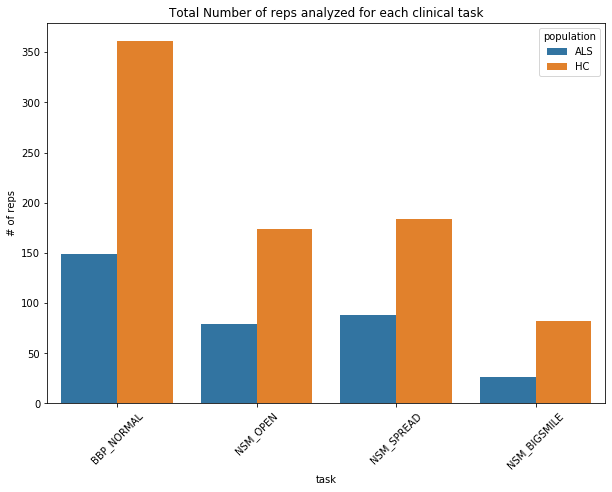

In [216]:
ax, figure = plt.subplots(figsize=(10,7))
g = sns.countplot(x='task',data=als_df,hue='population')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# set axes labels and title
plt.ylabel('# of reps')
plt.title('Total Number of reps analyzed for each clinical task')
plt.show()

In [217]:
#bbp_als_df_1.loc[~bbp_als_df_.subject_id.isin(a.subject_id)]



In [150]:

np.intersect1d(diego_bbp.subject_id.unique(),neuroface_subjects)



array(['A008', 'A009', 'A010', 'A011', 'A014', 'A016', 'A017'],
      dtype=object)

Features of the tasks seperated into repetitions 

In [14]:
# Standardized BBP 

path4 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

bbp_df = pd.read_csv(path4)

print(len(bbp_df))
print(len(bbp_df.columns))
print(bbp_df.columns)
print(bbp_df.subject_id.unique())
bbp_df.head()


# Standardized Open

path6 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_OPEN_standardized.csv'

open_df = pd.read_csv(path6)

print(len(open_df))
print(len(open_df.columns))
print(open_df.subject_id.unique())
print(open_df.columns)
open_df.head()

# Standardized Big Smile

path5 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_BIGSMILE_standardized.csv'

bigs_df = pd.read_csv(path5)

print(len(bigs_df))
print(len(bigs_df.columns))
print(bigs_df.columns)
print(bigs_df.subject_id.unique())
bigs_df.head()


# Standardized Spread

path7 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_SPREAD_standardized.csv'

spread_df = pd.read_csv(path7)

print(len(spread_df))
print(len(spread_df.columns))
print(spread_df.columns)
print(spread_df.subject_id.unique())
spread_df.head()

79
21
['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'NF11' 'NF12' 'NF17' 'NF18'
 'NF01' 'NF02' 'NF03' 'NF04' 'NF07' 'NF10']
Index(['Unnamed: 0', 'subject_id', 'task', 'type', 'rep', 'LL_PATH', 'A_MEAN',
       'A_RANGE', 'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN',
       'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN',
       'HEIGHT_VEL_MAX', 'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE'],
      dtype='object')


,Unnamed: 0,subject_id,task,type,rep,LL_PATH,A_MEAN,A_RANGE,A_ABS_DIFF,A_CCC,...,WIDTH_MEAN,WIDTH_VEL_MAX,WIDTH_VEL_MIN,HEIGHT_MAX,HEIGHT_MIN,HEIGHT_VEL_MAX,HEIGHT_VEL_MIN,R_SYMM,E_MEAN,E_RANGE
0,0,A001,NSM_OPEN,1,1,-0.203141,0.993852,0.740749,0.179625,-1.146813,...,0.408442,0.139503,0.318688,0.175377,-0.096755,-0.354331,-0.216170,-1.129932,-0.046916,0.359396
1,1,A001,NSM_OPEN,1,2,-0.002774,0.995576,0.490115,-0.039255,-0.244934,...,0.653615,-0.129659,0.359342,0.430000,2.266914,-0.291962,0.052390,-0.062699,-0.426236,0.400274
2,2,A001,NSM_OPEN,1,3,0.166772,1.654185,1.047016,0.464257,-1.590620,...,0.232597,0.108865,-0.302764,0.406607,1.443018,-0.295304,-0.010295,-1.156590,-0.335211,0.064580
3,3,A001,NSM_OPEN,1,4,0.350153,1.041140,0.903658,-0.019108,-0.326361,...,0.504072,-0.151487,0.220538,0.506437,-0.103253,-0.176378,0.050260,-0.029149,-0.486190,0.926023
4,4,A001,NSM_OPEN,1,5,-0.054048,1.435868,0.840615,0.398124,-1.509214,...,1.006171,-0.050515,0.052295,0.297936,1.066448,-0.275223,-0.091375,-0.759849,0.117021,-0.771053


Plotting the corrolation of the 

In [ ]:
stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

for f in stroke_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    sns.scatterplot(x='Tot_avg', y=f, data=df_f2, hue='subject_id')

    # calculate spearman's correlation
    corr, _ = spearmanr(df_f2[f], df_f2['Tot_avg'])
    print('Spearmans correlation: %.3f' % corr)

## Stroke data

In [17]:
# SLP SCORES

path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Stroke/SLP_Assessment_PS.csv'
ps_df = pd.read_csv(path)

ps_df = ps_df.drop('Unnamed: 8', axis=1)

# average of the clinical scores 

ps_df['Tot_avg'] = ps_df.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
ps_df['Symmetry_avg'] = ps_df.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
ps_df['ROM_avg'] = ps_df.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
ps_df['Speed_avg'] = ps_df.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
ps_df['Variability_avg'] = ps_df.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
ps_df['Fatigue_avg'] = ps_df.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)



print('len: ', len(ps_df))
print(ps_df.columns)
print(ps_df['Subject ID'].unique())
ps_df.head()

len:  105
Index(['File Name', 'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)',
       'Speed (SLP1)', 'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)',
       'Symmetry (SLP2)', 'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)',
       'Fatigue (SLP2)', 'Tot (SLP2)', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg'],
      dtype='object')
['OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007' 'S008'
 'S009' 'S011' 'S012' 'S013']


,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),Speed (SLP2),Variability (SLP2),Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg
0,OP01_02_BBP_NORMAL_color.avi,OP01,2,2,3,2,2,11,2,1,2,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5
1,OP01_02_DDK_PATAKA_color.avi,OP01,2,1,3,3,2,11,2,1,2,2,1,8,9.5,2.0,1.0,2.5,2.5,1.5
2,OP01_02_DDK_PA_color.avi,OP01,2,2,2,2,2,10,3,2,3,1,1,10,10.0,2.5,2.0,2.5,1.5,1.5
3,OP01_02_NSM_BIGSMILE_color.avi,OP01,2,2,2,1,1,8,2,1,1,1,1,6,7.0,2.0,1.5,1.5,1.0,1.0
4,OP01_02_NSM_BROW_color.avi,OP01,1,1,1,1,2,6,1,2,1,1,1,6,6.0,1.0,1.5,1.0,1.0,1.5


In [18]:
tasks = ['BBP_NORMAL', 'PA', 'PATAKA', 'BLOW', 'KISS', 'OPEN', 'SPREAD', 'BIGSMILE', 'BROW']

def task_labeler(row):
    for t in tasks: 
        if t in row: 
            return t
    

ps_df['task'] = [task_labeler(x) for x in ps_df['File Name']]

ps_df.head()

,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),...,Variability (SLP2),Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task
0,OP01_02_BBP_NORMAL_color.avi,OP01,2,2,3,2,2,11,2,1,...,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5,BBP_NORMAL
1,OP01_02_DDK_PATAKA_color.avi,OP01,2,1,3,3,2,11,2,1,...,2,1,8,9.5,2.0,1.0,2.5,2.5,1.5,PA
2,OP01_02_DDK_PA_color.avi,OP01,2,2,2,2,2,10,3,2,...,1,1,10,10.0,2.5,2.0,2.5,1.5,1.5,PA
3,OP01_02_NSM_BIGSMILE_color.avi,OP01,2,2,2,1,1,8,2,1,...,1,1,6,7.0,2.0,1.5,1.5,1.0,1.0,BIGSMILE
4,OP01_02_NSM_BROW_color.avi,OP01,1,1,1,1,2,6,1,2,...,1,1,6,6.0,1.0,1.5,1.0,1.0,1.5,BROW


In [19]:
print(ps_df.shape)
print(ps_df['Subject ID'].unique())

(105, 21)
['OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007' 'S008'
 'S009' 'S011' 'S012' 'S013']


In [20]:
ps_df_bbp = ps_df[ps_df['task']== 'BBP_NORMAL']

In [21]:
print(ps_df.shape)

print(ps_df_bbp.shape)
print(ps_df_bbp['Subject ID'].unique())
ps_df_bbp.head()

(105, 21)
(14, 21)
['OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007' 'S008'
 'S009' 'S011' 'S012' 'S013']


,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),...,Variability (SLP2),Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task
0,OP01_02_BBP_NORMAL_color.avi,OP01,2,2,3,2,2,11,2,1,...,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5,BBP_NORMAL
8,OP02_02_BBP_NORMAL_color.avi,OP02,2,1,2,1,1,7,2,1,...,1,1,7,7.0,2.0,1.0,2.0,1.0,1.0,BBP_NORMAL
16,OP03_02_BBP_NORMAL_color.avi,OP03,1,1,1,1,1,5,1,1,...,1,1,5,5.0,1.0,1.0,1.0,1.0,1.0,BBP_NORMAL
24,S001_02_BBP_NORMAL_color.avi,S001,3,1,2,4,1,11,3,2,...,4,2,13,12.0,3.0,1.5,2.0,4.0,1.5,BBP_NORMAL
31,S002_02_BBP_NORMAL_color.avi,S002,3,2,4,4,1,14,3,2,...,4,1,13,13.5,3.0,2.0,3.5,4.0,1.0,BBP_NORMAL


In [22]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_BBP_NORMAL_standardized.csv'

s_bbp_df = pd.read_csv(path)

print('len: ' , len(s_bbp_df))
print(len(s_bbp_df.columns))
print(s_bbp_df.columns)
print(s_bbp_df.subject_id.unique())
print(s_bbp_df.task.unique())
s_bbp_df.head()

len:  457
19
Index(['Unnamed: 0', 'subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN',
       'O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3'],
      dtype='object')
['NF11' 'NF12' 'NF13' 'NF14' 'NF15' 'NF16' 'NF17' 'NF18' 'NF19' 'NF20'
 'NF21' 'NF22' 'NF24' 'NF26' 'NF27' 'NF00' 'NF02' 'NF03' 'NF04' 'NF05'
 'NF06' 'NF07' 'NF08' 'NF09' 'NF10' 'OP01' 'OP02' 'OP03' 'OP05' 'OP06'
 'OP07' 'OP08' 'OP09' 'OP10' 'OP12' 'S001' 'S002' 'S003' 'S005' 'S006'
 'S007' 'S008' 'S009' 'S010' 'S013']
['BBP_NORMAL']


,Unnamed: 0,subject_id,task,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,W_MIN,W_MAX_VEL,W_MIN_VEL,A_MOUTH,R_LCRC,D_0,D_1,D_2,D_3
0,0,NF11,BBP_NORMAL,0,1,-0.113784,0.101184,-0.094766,0.104099,-0.102612,-0.192593,-0.096646,0.090399,-0.073213,-0.775730,-0.136865,-0.087322,-0.140752,-0.099467
1,1,NF11,BBP_NORMAL,0,2,-0.126145,-0.010132,-0.074803,0.113766,-0.119388,-0.247239,-0.108232,0.106958,-0.128275,-1.209708,-0.082621,-0.092922,-0.143255,-0.113881
2,2,NF11,BBP_NORMAL,0,3,-0.142563,0.211797,-0.079372,0.072099,-0.131001,-0.292026,-0.131967,0.108595,-0.154483,-0.241926,-0.096537,-0.089414,-0.122998,-0.152515
3,3,NF11,BBP_NORMAL,0,4,-0.140305,0.189925,-0.053704,0.094888,-0.128350,-0.105882,-0.126109,0.103573,-0.058588,-0.931032,-0.143598,-0.092836,-0.121812,-0.119750
4,4,NF11,BBP_NORMAL,0,5,-0.152125,0.027831,-0.087530,0.123958,-0.072734,0.242131,-0.099216,0.078855,0.002796,0.028873,-0.130839,-0.061820,-0.137479,-0.169899


In [23]:
df_f = s_bbp_df.merge(ps_df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')

print(df_f.size)
print(df_f.shape)
print(ps_df_bbp.shape)
print(s_bbp_df.shape)
print('len: ', len(df_f))

print(df_f.Tot_avg.isnull().count())

df_f.Tot_avg

4680
(117, 40)
(14, 21)
(457, 19)
len:  117
117


0      9.0
1      9.0
2      9.0
3      9.0
4      9.0
      ... 
112    7.5
113    7.5
114    7.5
115    7.5
116    7.5
Name: Tot_avg, Length: 117, dtype: float64

In [25]:
df_f.head()

,Unnamed: 0,subject_id,task_x,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,...,Variability (SLP2),Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task_y
0,258,OP01,BBP_NORMAL,1,1,7.341936,-0.504500,2.623839,-7.979108,5.724481,...,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5,BBP_NORMAL
1,259,OP01,BBP_NORMAL,1,2,-0.068703,0.151367,-0.066905,0.103075,-0.187590,...,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5,BBP_NORMAL
2,260,OP01,BBP_NORMAL,1,3,-0.051567,0.209626,-0.076829,0.083460,-0.187825,...,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5,BBP_NORMAL
3,261,OP01,BBP_NORMAL,1,4,-0.059029,0.152812,-0.078021,0.043559,-0.135430,...,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5,BBP_NORMAL
4,262,OP01,BBP_NORMAL,1,5,-0.133809,0.292205,-0.065467,0.076636,-0.203743,...,1,1,7,9.0,2.0,1.5,2.5,1.5,1.5,BBP_NORMAL


In [26]:
df_f.subject_id.unique()

array(['OP01', 'OP02', 'OP03', 'S001', 'S002', 'S003', 'S005', 'S006',
       'S007', 'S008', 'S009', 'S013'], dtype=object)

//anaconda3/envs/csc2541/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


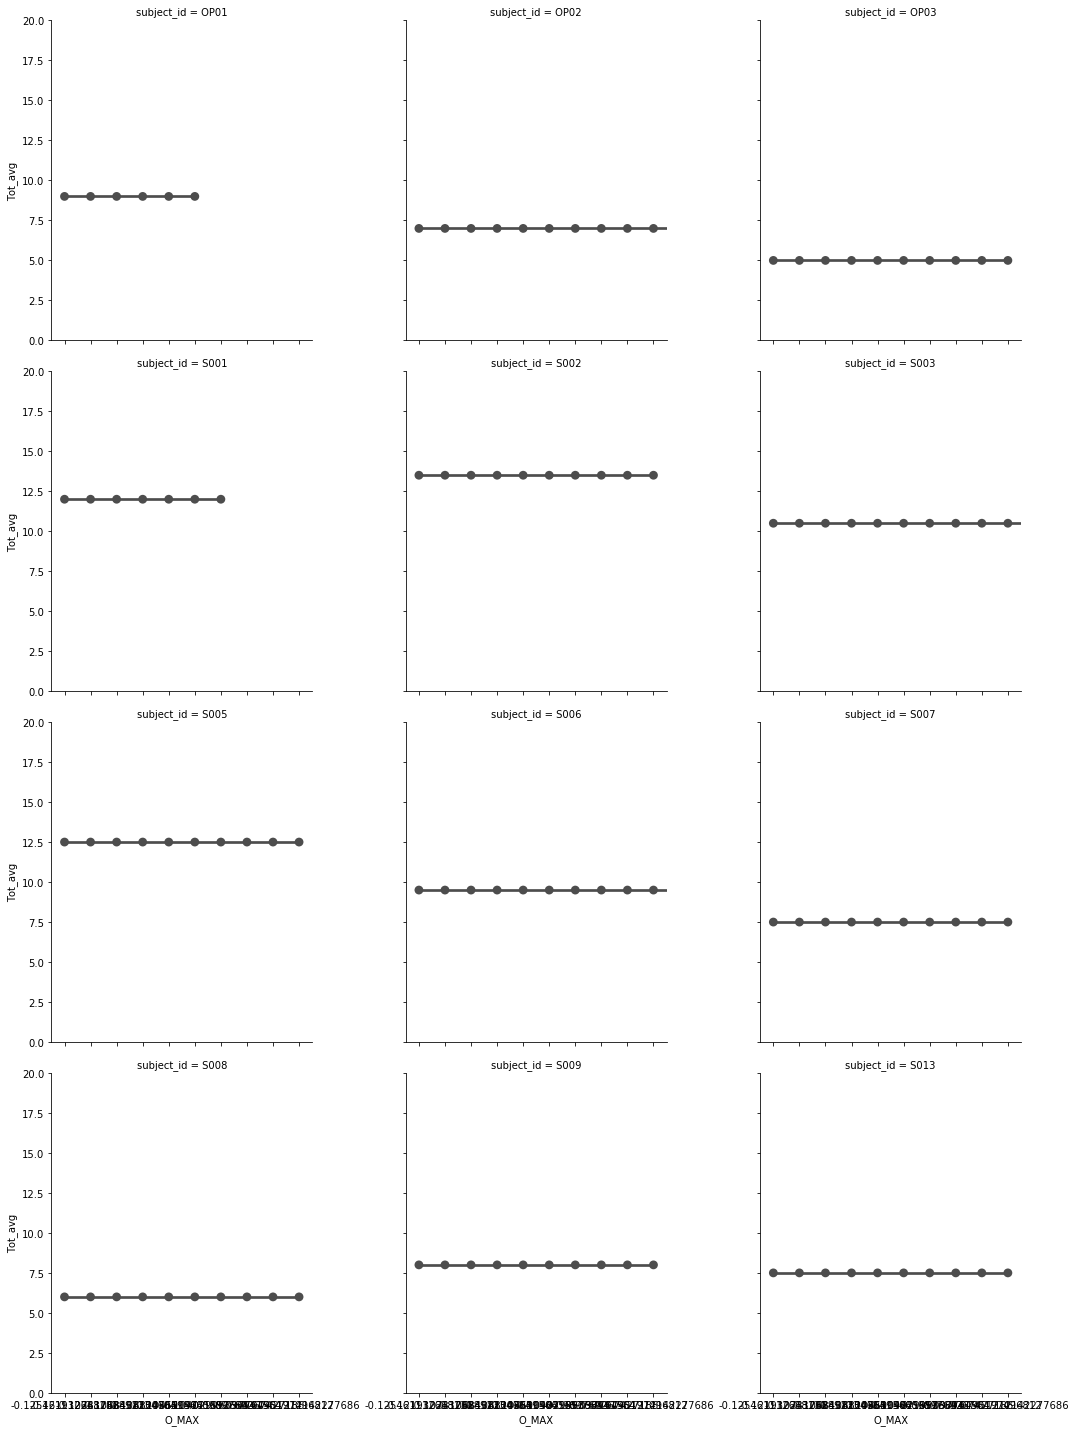

In [27]:
g = sns.FacetGrid(df_f, col="subject_id", col_wrap=3, height=5, ylim=(0, 20))
g.map(sns.pointplot, "O_MAX", "Tot_avg",color=".3", ci=None);

Spearmans correlation: 0.492


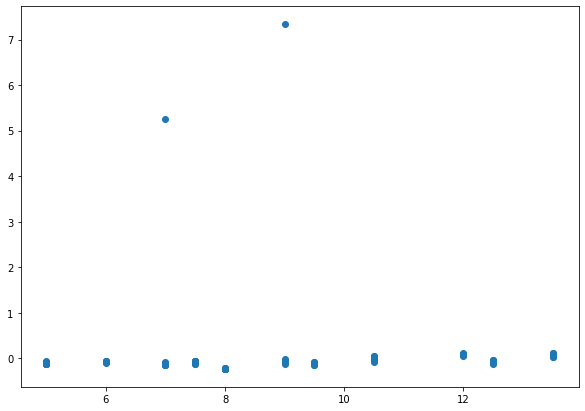

In [28]:
ax, figure = plt.subplots(figsize=(10,7))
plt.scatter(df_f['Tot_avg'], df_f["O_MAX"])


# calculate spearman's correlation
corr, _ = spearmanr(df_f["O_MAX"], df_f['Tot_avg'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: 0.492


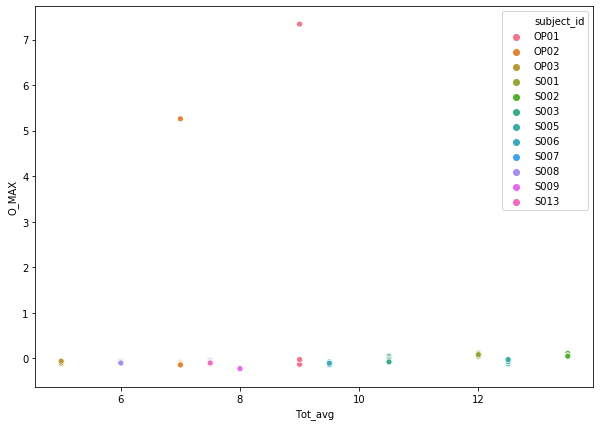

In [29]:
ax, figure = plt.subplots(figsize=(10,7))
sns.scatterplot(x='Tot_avg', y="O_MAX", data=df_f, hue='subject_id')

# calculate spearman's correlation
corr, _ = spearmanr(df_f["O_MAX"], df_f['Tot_avg'])
print('Spearmans correlation: %.3f' % corr)

In [30]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

s_bbp2_df = pd.read_csv(path)

print(len(s_bbp2_df))
print(len(s_bbp2_df.columns))
print(s_bbp2_df.columns)
print(s_bbp2_df.subject_id.unique())
s_bbp2_df

220
19
Index(['Unnamed: 0', 'subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN',
       'O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3'],
      dtype='object')
['NF11' 'NF12' 'NF17' 'NF18' 'NF02' 'NF03' 'NF04' 'NF07' 'NF08' 'NF10'
 'OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007' 'S008'
 'S009' 'S013']


,Unnamed: 0,subject_id,task,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,W_MIN,W_MAX_VEL,W_MIN_VEL,A_MOUTH,R_LCRC,D_0,D_1,D_2,D_3
0,0,NF11,BBP_NORMAL,0,1,-0.153850,0.067469,-0.127571,0.114557,-0.174261,-0.132163,-0.153166,0.146051,-0.085870,-0.822195,-0.323373,-0.299220,-0.382514,-0.204507
1,1,NF11,BBP_NORMAL,0,2,-0.173778,-0.036784,-0.079753,0.131914,-0.205970,-0.199355,-0.175930,0.186285,-0.142509,-1.292253,-0.207868,-0.333824,-0.389672,-0.239242
2,2,NF11,BBP_NORMAL,0,3,-0.200246,0.171062,-0.090696,0.057104,-0.227919,-0.254424,-0.222564,0.190262,-0.169468,-0.244012,-0.237501,-0.312145,-0.331760,-0.332348
3,3,NF11,BBP_NORMAL,0,4,-0.196607,0.150579,-0.029215,0.098019,-0.222909,-0.025545,-0.211056,0.178060,-0.070825,-0.990408,-0.337710,-0.333296,-0.328368,-0.253388
4,4,NF11,BBP_NORMAL,0,5,-0.215663,-0.001229,-0.110237,0.150213,-0.117786,0.402364,-0.158217,0.118003,-0.007682,0.049300,-0.310541,-0.141619,-0.373157,-0.374241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,215,S013,BBP_NORMAL,1,6,-0.128024,-0.538340,-0.153183,0.125250,-0.324346,-0.907508,-0.170731,0.161222,-0.138739,-1.640850,-0.147222,-0.042033,-0.357362,0.297985
216,216,S013,BBP_NORMAL,1,7,-0.129978,-0.206401,-0.160850,0.133120,-0.329384,-0.972619,-0.181456,0.168215,-0.147840,-1.023871,-0.262066,-0.192240,-0.339665,0.262536
217,217,S013,BBP_NORMAL,1,8,-0.142659,-0.580889,-0.164951,0.118297,-0.315087,-1.393893,-0.189538,0.157653,-0.161647,-1.504379,-0.296490,-0.140436,-0.320498,0.227059
218,218,S013,BBP_NORMAL,1,9,-0.142253,-1.166367,-0.165194,0.125033,-0.292660,-2.617042,-0.166532,0.140278,-0.149434,-1.174292,-0.319441,-0.167717,-0.349458,0.395011


In [31]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

als_bbp2_df = pd.read_csv(path)

print(len(als_bbp2_df))
print(len(als_bbp2_df.columns))
print(als_bbp2_df.columns)
print(als_bbp2_df.subject_id.unique())
als_bbp2_df

164
21
Index(['Unnamed: 0', 'subject_id', 'task', 'type', 'rep', 'LL_PATH', 'A_MEAN',
       'A_RANGE', 'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN',
       'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN',
       'HEIGHT_VEL_MAX', 'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE'],
      dtype='object')
['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'NF11' 'NF12' 'NF17' 'NF18'
 'NF02' 'NF03' 'NF04' 'NF07' 'NF08' 'NF10']


,Unnamed: 0,subject_id,task,type,rep,LL_PATH,A_MEAN,A_RANGE,A_ABS_DIFF,A_CCC,...,WIDTH_MEAN,WIDTH_VEL_MAX,WIDTH_VEL_MIN,HEIGHT_MAX,HEIGHT_MIN,HEIGHT_VEL_MAX,HEIGHT_VEL_MIN,R_SYMM,E_MEAN,E_RANGE
0,0,A001,BBP_NORMAL,1,1,-0.215870,0.136869,-0.176957,-0.613247,0.346506,...,0.295740,-0.778744,0.780765,-0.227367,-0.191740,0.461185,-0.072427,0.972327,0.225458,-0.483531
1,1,A001,BBP_NORMAL,1,2,-0.337222,0.153676,-0.104392,-0.752957,0.388989,...,0.025944,-0.646191,0.246260,0.010325,0.090365,0.599250,0.290242,0.902949,0.013954,0.056602
2,2,A001,BBP_NORMAL,1,3,-0.358441,0.181225,0.066887,-0.756891,0.428300,...,0.335881,-0.795324,0.090749,0.014513,-0.174053,0.836964,-0.224743,1.047625,0.211090,0.029828
3,3,A001,BBP_NORMAL,1,4,-0.149013,0.200017,0.008100,-0.640854,0.335648,...,-0.032402,-0.594184,0.391334,0.022435,0.129439,0.521974,-0.424736,1.019186,0.305663,-0.174827
4,4,A001,BBP_NORMAL,1,5,-0.205890,0.058934,0.078543,-0.718055,0.408061,...,-0.320478,-0.834177,0.305702,-0.053124,-0.237576,-0.044338,-0.031636,0.708230,0.403195,-0.220440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,159,NF10,BBP_NORMAL,0,6,-0.322232,-0.195498,-0.422798,-0.109938,0.555639,...,-1.080652,0.308631,0.285441,-0.564913,0.172103,-0.195530,0.310597,0.331116,-0.063823,-0.381874
160,160,NF10,BBP_NORMAL,0,7,-0.173137,-0.223798,-0.458671,0.227347,0.443875,...,-1.332456,-0.169821,0.357892,-0.579755,-0.545630,-0.301016,0.429093,0.912383,-0.226101,0.339262
161,161,NF10,BBP_NORMAL,0,8,-0.146706,0.014401,-0.504032,-0.172145,0.588748,...,-0.815099,0.281922,0.439188,-0.446125,0.157364,-0.493484,-0.224104,0.924887,-0.502204,0.337775
162,162,NF10,BBP_NORMAL,0,9,-0.182033,0.092545,-0.068582,0.178816,0.506530,...,-0.579719,-0.256693,0.250287,-0.283949,-0.308225,-0.387322,0.072600,0.538645,-0.511675,-0.106963


### BBP_NORMAL ACROSS ALL SUBJECTS ANALYSIS

In [32]:
# obtaining the clinical data for bbp task only 
df_bbp = slp_scores[slp_scores['task']== 'BBP_NORMAL']

# merging the clinical data with the features 
df_f1 = als_bbp2_df.merge(df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')
df_f2 = s_bbp2_df.merge(df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')

print(df_f1.subject_id.unique())
print(df_f2.subject_id.unique())


['A008' 'A009' 'A010' 'A011']
['OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007' 'S008'
 'S009' 'S013']


In [33]:
df_f1.columns

Index(['Unnamed: 0', 'subject_id', 'task_x', 'type', 'rep', 'LL_PATH',
       'A_MEAN', 'A_RANGE', 'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN',
       'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN',
       'HEIGHT_VEL_MAX', 'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE',
       'File Name', 'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)',
       'Speed (SLP1)', 'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)',
       'Symmetry (SLP2)', 'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)',
       'Fatigue (SLP2)', 'Tot (SLP2)', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg', 'task_y'],
      dtype='object')

In [34]:
df_f2.columns

Index(['Unnamed: 0', 'subject_id', 'task_x', 'type', 'rep', 'O_MAX', 'O_MIN',
       'O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3', 'File Name',
       'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)', 'Speed (SLP1)',
       'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)', 'Symmetry (SLP2)',
       'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)', 'Fatigue (SLP2)',
       'Tot (SLP2)', 'Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg',
       'Variability_avg', 'Fatigue_avg', 'task_y'],
      dtype='object')

Spearmans correlation: 0.492
Spearmans correlation: -0.115
Spearmans correlation: 0.138
Spearmans correlation: -0.275
Spearmans correlation: 0.272
Spearmans correlation: -0.349
Spearmans correlation: 0.086
Spearmans correlation: -0.119
Spearmans correlation: 0.539
Spearmans correlation: 0.183


<ipython-input-35-adf540c53383>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-35-adf540c53383>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax, figure = plt.subplots(figsize=(10,7))


Spearmans correlation: 0.319
Spearmans correlation: 0.050
Spearmans correlation: 0.384
Spearmans correlation: 0.265


<Figure size 432x288 with 0 Axes>

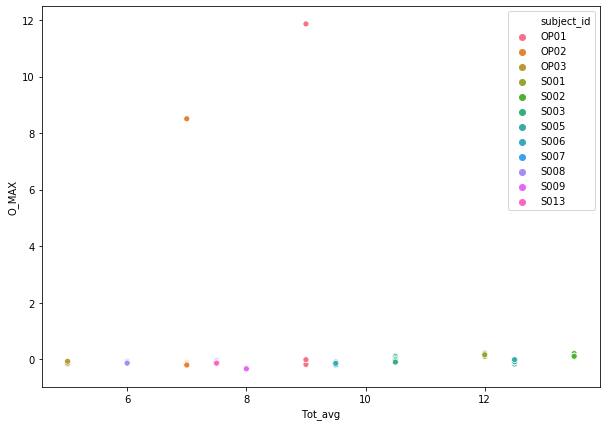

<Figure size 432x288 with 0 Axes>

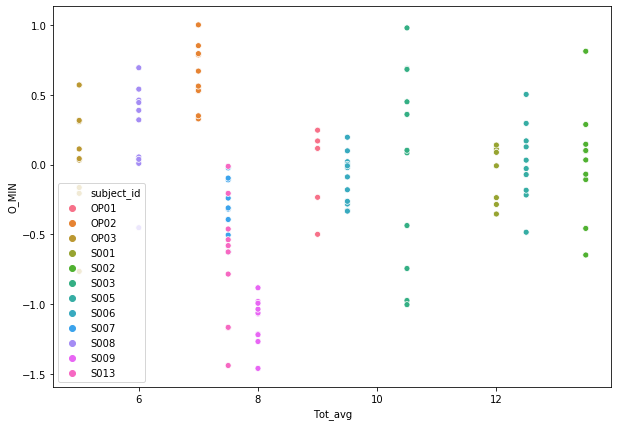

<Figure size 432x288 with 0 Axes>

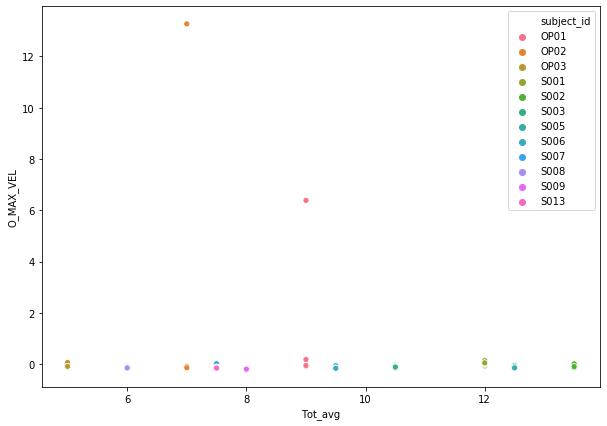

<Figure size 432x288 with 0 Axes>

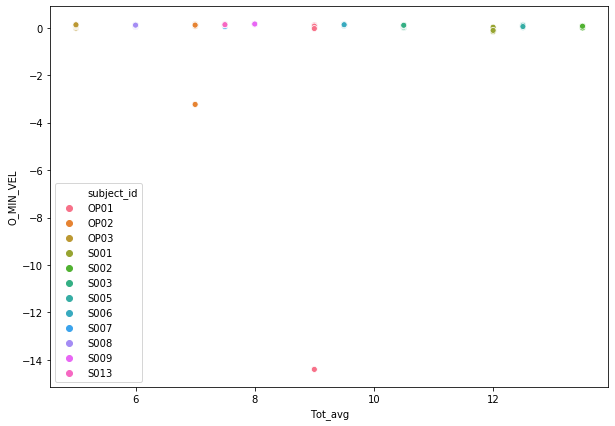

<Figure size 432x288 with 0 Axes>

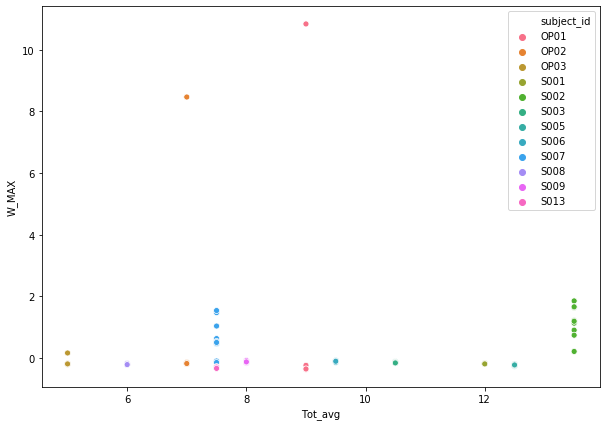

<Figure size 432x288 with 0 Axes>

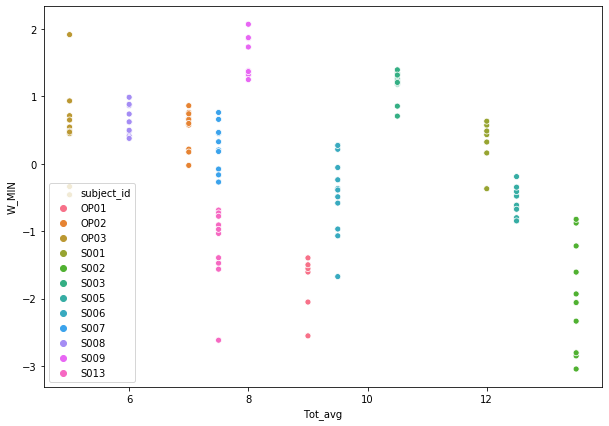

<Figure size 432x288 with 0 Axes>

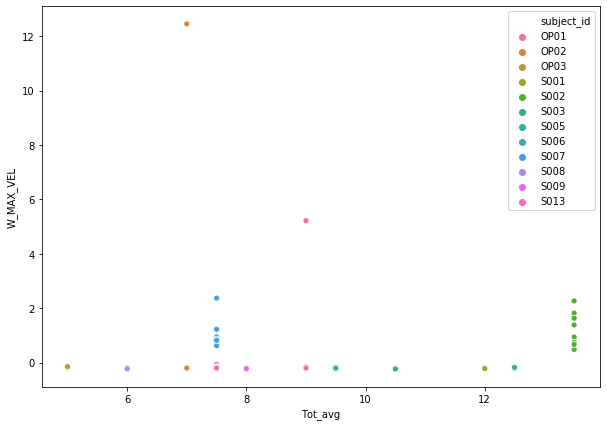

<Figure size 432x288 with 0 Axes>

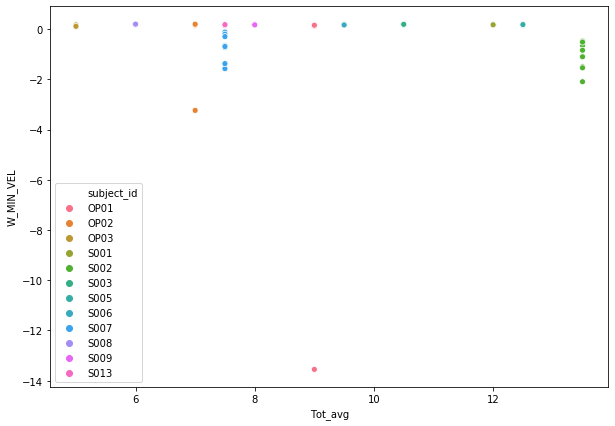

<Figure size 432x288 with 0 Axes>

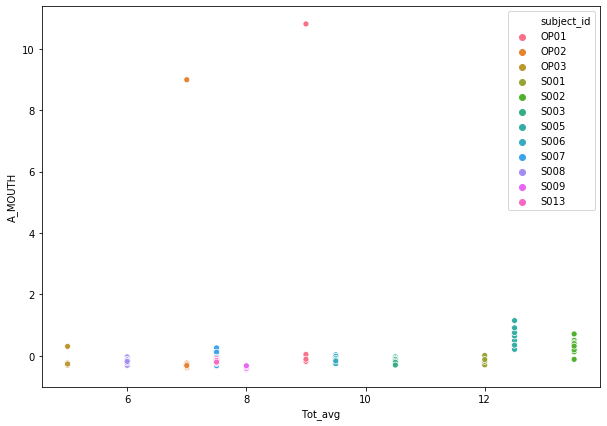

<Figure size 432x288 with 0 Axes>

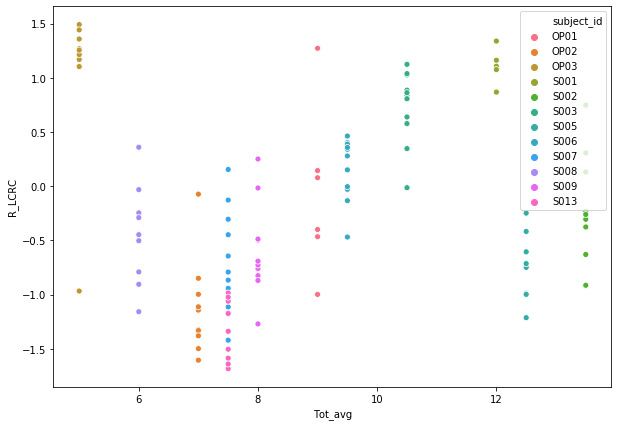

<Figure size 432x288 with 0 Axes>

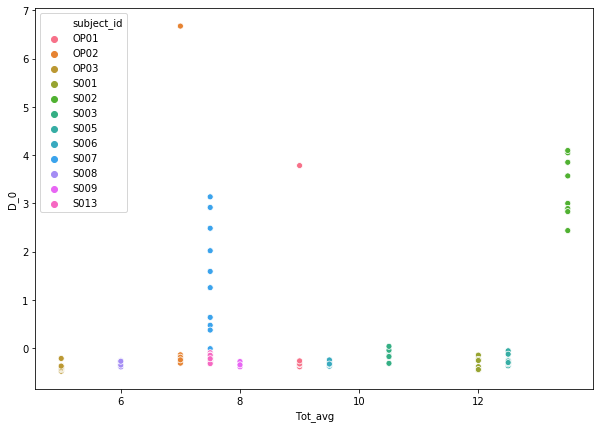

<Figure size 432x288 with 0 Axes>

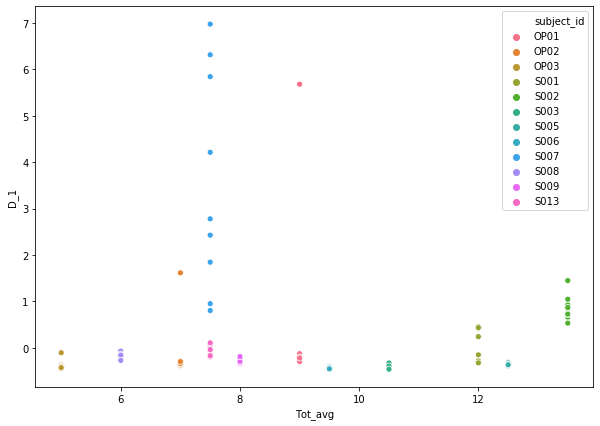

<Figure size 432x288 with 0 Axes>

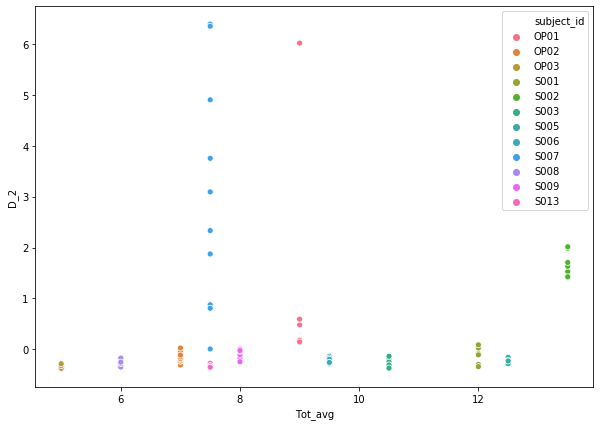

<Figure size 432x288 with 0 Axes>

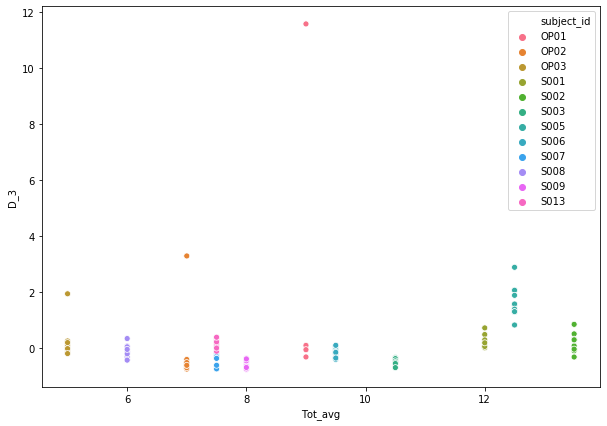

In [35]:
stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

for f in stroke_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    sns.scatterplot(x='Tot_avg', y=f, data=df_f2, hue='subject_id')

    # calculate spearman's correlation
    corr, _ = spearmanr(df_f2[f], df_f2['Tot_avg'])
    print('Spearmans correlation: %.3f' % corr)

In [36]:
stroke_to_regr_df = df_f2[['subject_id', 'task_x','Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg',
       'Variability_avg', 'Fatigue_avg', 'O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']]



In [37]:
stroke_to_regr_df

,subject_id,task_x,Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,O_MAX,O_MIN,...,W_MAX,W_MIN,W_MAX_VEL,W_MIN_VEL,A_MOUTH,R_LCRC,D_0,D_1,D_2,D_3
0,OP01,BBP_NORMAL,9.0,2.0,1.5,2.5,1.5,1.5,11.866159,-0.499780,...,10.839825,-2.552668,5.221481,-13.548835,10.812805,1.271911,3.785621,5.679406,6.016835,11.581844
1,OP01,BBP_NORMAL,9.0,2.0,1.5,2.5,1.5,1.5,-0.081171,0.114467,...,-0.334882,-1.605875,-0.212864,0.127517,0.026321,-0.466587,-0.386891,-0.273429,0.481474,-0.032596
2,OP01,BBP_NORMAL,9.0,2.0,1.5,2.5,1.5,1.5,-0.053544,0.169029,...,-0.335325,-1.554507,-0.194152,0.134802,0.012254,-0.399881,-0.325032,-0.293742,0.593108,0.090102
3,OP01,BBP_NORMAL,9.0,2.0,1.5,2.5,1.5,1.5,-0.065575,0.115820,...,-0.236292,-2.051061,-0.155043,0.120297,-0.183913,-0.998433,-0.340032,-0.123498,0.145489,0.101307
4,OP01,BBP_NORMAL,9.0,2.0,1.5,2.5,1.5,1.5,-0.186134,0.246368,...,-0.365414,-1.396007,-0.209402,0.128120,0.042706,0.077433,-0.326653,-0.196018,0.181002,-0.309762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,S013,BBP_NORMAL,7.5,1.5,1.5,2.5,1.0,1.0,-0.128024,-0.538340,...,-0.324346,-0.907508,-0.170731,0.161222,-0.138739,-1.640850,-0.147222,-0.042033,-0.357362,0.297985
113,S013,BBP_NORMAL,7.5,1.5,1.5,2.5,1.0,1.0,-0.129978,-0.206401,...,-0.329384,-0.972619,-0.181456,0.168215,-0.147840,-1.023871,-0.262066,-0.192240,-0.339665,0.262536
114,S013,BBP_NORMAL,7.5,1.5,1.5,2.5,1.0,1.0,-0.142659,-0.580889,...,-0.315087,-1.393893,-0.189538,0.157653,-0.161647,-1.504379,-0.296490,-0.140436,-0.320498,0.227059
115,S013,BBP_NORMAL,7.5,1.5,1.5,2.5,1.0,1.0,-0.142253,-1.166367,...,-0.292660,-2.617042,-0.166532,0.140278,-0.149434,-1.174292,-0.319441,-0.167717,-0.349458,0.395011


## Running RF Regression on the data

In [38]:
def regressor(data, regr, col): 
    
    # col will tell us which clinical score we will predict, there are 5 of them 
    # regr is the type of regression model we use, start testing with rf regressor
    # data is the df 
    
    # we will do leave one subject out for evaluating the model 
    subjects  = data['subject_id'].unique()
    
    all_y = []
    all_y_star = []

    all_y_subject = []
    all_prob_subject = []
    
    for s in subjects: 
        values_train = data.loc[data.subject_id != s].values  
        
        ##### need to change this based on the df structure in my setup!!!!!!!!!
        ### change 4, for y is already made the change 
        X_train = values_train[:,8:]
        y_train = values_train[:,col]

        values_test = data.loc[data.subject_id == s].values  
        X_test = values_test[:,8:]
        # reps of the same task for a given subject 
        y_test = values_test[:,col]
        

        regr_fit = regr.fit(X_train,y_train)
        results = regr_fit.predict(X_test)#[:,1]
        
        all_y.append(y_test)
        all_y_star.append(results)
        
        
           # average out the predictions of the reps of the task to get one final vlue for clinical score
        all_y_subject.append(np.mean(y_test[:]))
        all_prob_subject.append(np.mean(results[:]))
        
        #print(clf_fit.feature_importances_)
        #print('y-all-subj: ' , all_y_subject)
        #print('y_all_star-subj: ', all_prob_subject)
        

    
    #flat_list_y = [item for sublist in all_y for item in sublist]
    #flat_list_prob = [item for sublist in all_y_star for item in sublist]
    
    #print('y-all-flat: ' , flat_list_y)
    #print('y_all_star-flat: ', flat_list_prob)
    #return np.array(all_y_subject).astype(int),np.array(all_prob_subject), np.array(flat_list_y).astype(int), np.array(flat_list_prob)
    return np.array(all_y_subject), np.array(all_prob_subject)

In [39]:
### BBP_NORMAL Task 

regr = RandomForestRegressor(n_jobs=-1, random_state=42)

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0 # 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE




#file = r".\results\test_multi_finetuned\metric_output_"+tasks[task]+".csv"
#Data_3D = pd.read_csv(file, index_col=0)

clinical_measure = ['Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg','Variability_avg', 'Fatigue_avg']
col = 3  # 2-> Tot_avg, 3-> Symmetry_avg, 4-> ROM_avg, 5-> Speed_avg, 6-> Variability_avg, 7-> Fatigue_avg
#all_y_subject_finetuned,all_prob_subject_finetuned,all_y_finetuned,all_prob_finetuned = regressor(Data_3D, regr)

all_y_subject_finetuned,all_prob_subject_finetuned = regressor(stroke_to_regr_df, regr, col)

idx = col-3
print('clinical_measure: ', clinical_measure[idx])
print("y: ",all_y_subject_finetuned)
print("prediction: ",all_prob_subject_finetuned)
print()

if 0:

    fpr_finetuned, tpr_finetuned, thresholds_finetuned = roc_curve(all_y_subject_finetuned,all_prob_subject_finetuned,pos_label=0)
    roc_auc_finetuned= auc(fpr_finetuned, tpr_finetuned)



    plt.figure(1, figsize=(12,6))
    plt.plot(fpr_finetuned, tpr_finetuned, lw=2, alpha=0.75, color='r');

    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100),'k')
    plt.ylabel('True Positive');
    plt.xlabel('False Positive');
    plt.legend(['finetuned model - AUC ='+str(np.round(roc_auc_finetuned,2))]);

clinical_measure:  Tot_avg
y:  [2.  2.  1.  3.  3.  2.5 4.  3.  2.5 1.  3.5 1.5]
prediction:  [2.56666667 2.87045455 2.213      1.91785714 2.5265     2.08
 1.4785     2.56041667 2.877      2.0345     2.292      1.5615    ]



In [40]:
tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0 # 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE


file = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
Data_3D = pd.read_csv(file, index_col=0)
Data_3D

,subject_id,task,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,W_MIN,W_MAX_VEL,W_MIN_VEL,A_MOUTH,R_LCRC,D_0,D_1,D_2,D_3
0,NF11,BBP_NORMAL,0,1,2.286921,1.022002,0.594900,-0.544603,1.077094,0.876171,0.119329,-0.104292,2.098207,0.215262,0.975132,1.049206,0.568557,1.173047
1,NF11,BBP_NORMAL,0,2,2.188607,0.996711,0.820745,-0.436266,1.044838,0.870372,0.095685,-0.054182,1.825080,0.091104,1.491866,0.899794,0.533262,1.128183
2,NF11,BBP_NORMAL,0,3,2.058023,1.047133,0.769061,-0.903222,1.022509,0.865620,0.047249,-0.049228,1.695076,0.367979,1.359297,0.993397,0.818813,1.007924
3,NF11,BBP_NORMAL,0,4,2.075979,1.042164,1.059445,-0.647830,1.027606,0.885372,0.059202,-0.064426,2.170755,0.170831,0.910991,0.902072,0.835538,1.109912
4,NF11,BBP_NORMAL,0,5,1.981968,1.005337,0.676766,-0.322046,1.134544,0.922301,0.114083,-0.139226,2.475245,0.445453,1.032537,1.729688,0.614693,0.953813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,OP12,BBP_NORMAL,1,7,2.109076,1.177423,0.551901,-0.674482,1.140421,0.938439,0.120129,-0.269593,0.294625,0.168077,0.446617,0.931822,0.563092,0.163666
253,OP12,BBP_NORMAL,1,8,2.311636,1.174281,0.876835,-0.820190,1.131411,0.920222,0.118820,-0.113605,0.608010,0.281208,0.276379,0.987086,0.639258,0.310965
254,OP12,BBP_NORMAL,1,9,1.723222,1.180619,0.557922,-0.278758,1.141900,0.955965,0.235853,-0.143427,0.339329,-0.020715,0.708920,1.053611,0.692576,0.257561
255,OP12,BBP_NORMAL,1,10,2.324338,1.183095,0.536093,-0.678166,1.118155,0.915359,0.209690,-0.152822,0.619460,0.282242,0.544911,0.800502,0.278837,0.329888


In [41]:
subjects_to_remove = 'NF11|OP01'




In [42]:
Data_3D.subject_id.unique()

array(['NF11', 'NF12', 'NF13', 'NF14', 'NF15', 'NF16', 'NF17', 'NF18',
       'NF19', 'NF20', 'NF21', 'NF22', 'NF24', 'NF26', 'NF27', 'OP01',
       'OP02', 'OP03', 'OP05', 'OP06', 'OP07', 'OP08', 'OP09', 'OP10',
       'OP12'], dtype=object)

In [43]:
Data_3D[Data_3D['subject_id'].str.contains(subjects_to_remove,regex=True)==False] 

,subject_id,task,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,W_MIN,W_MAX_VEL,W_MIN_VEL,A_MOUTH,R_LCRC,D_0,D_1,D_2,D_3
12,NF12,BBP_NORMAL,0,1,0.799730,0.449477,0.177887,-0.265700,1.105093,1.023100,0.049165,-0.047862,0.135760,0.052820,0.848014,0.665628,0.485684,0.619747
13,NF12,BBP_NORMAL,0,2,0.721853,0.411620,0.255060,-0.231682,1.091758,1.007876,0.052303,-0.082063,0.076651,0.088007,1.037506,0.445296,0.319454,0.448286
14,NF12,BBP_NORMAL,0,3,0.710018,0.410642,0.270776,-0.203547,1.097457,0.992237,0.053574,-0.053812,0.114176,0.055119,0.915209,0.500554,0.540968,0.388885
15,NF12,BBP_NORMAL,0,4,0.667796,0.423348,0.270754,-0.258058,1.077646,0.992126,0.082171,-0.068193,0.075253,0.113557,0.824646,0.551040,0.744383,0.563555
16,NF12,BBP_NORMAL,0,5,0.659020,0.428059,0.211174,-0.264721,1.122569,1.015614,0.065182,-0.078572,0.131577,-0.006711,0.328968,1.292824,0.737945,0.605369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,OP12,BBP_NORMAL,1,7,2.109076,1.177423,0.551901,-0.674482,1.140421,0.938439,0.120129,-0.269593,0.294625,0.168077,0.446617,0.931822,0.563092,0.163666
253,OP12,BBP_NORMAL,1,8,2.311636,1.174281,0.876835,-0.820190,1.131411,0.920222,0.118820,-0.113605,0.608010,0.281208,0.276379,0.987086,0.639258,0.310965
254,OP12,BBP_NORMAL,1,9,1.723222,1.180619,0.557922,-0.278758,1.141900,0.955965,0.235853,-0.143427,0.339329,-0.020715,0.708920,1.053611,0.692576,0.257561
255,OP12,BBP_NORMAL,1,10,2.324338,1.183095,0.536093,-0.678166,1.118155,0.915359,0.209690,-0.152822,0.619460,0.282242,0.544911,0.800502,0.278837,0.329888


In [ ]:
    
if 0:    
    path3 = r'/Users/denizjafari/documents/CODE/ClinicalScore/for_deniz.csv'

    df3 = pd.read_csv(path3)

    print(len(df3))
    print(df3.columns)
    df3.head()
    
    
# average of the clinical scores 

#df['Tot_avg'] = df.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
#df['Symmetry_avg'] = df.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
#df['ROM_avg'] = df.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
#df['Speed_avg'] = df.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
#df['Variability_avg'] = df.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
#df['Fatigue_avg'] = df.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)

# the ranges 


def clinical_severity(row):
    if row['Tot_avg'] ==5 :
        return 'Normal'
    if row['Tot_avg'] > 5 and row['Tot_avg'] <=10 :
        return 'Mild'
    if row['Tot_avg'] <=15 and row['Tot_avg'] > 10:
        return 'Moderate'
    if row['Tot_avg'] >15 :
        return 'Severe'
    return 'Wrong_Value'

#df['Clinical_Cat'] = df.apply (lambda row: clinical_severity(row), axis=1)

# lets see the severity of the oro-facial defecits in the clinical population 

if 0:
    sns.countplot(x='Clinical_Cat',data=df)
    # set axes labels and title
    plt.ylabel('Number of People')
    plt.title('Total Number of People in each Clinical category')
    plt.show()
    
if 0:
    plt.scatter(df['Tot (SLP1)'], df['Tot (SLP2)'])
    # calculate spearman's correlation
    corr, _ = spearmanr(df['Tot (SLP1)'], df['Tot (SLP2)'])
    print('Spearmans correlation: %.3f' % corr)
    
    
if 0:
    sns.boxplot(x=df['Subject ID'], y=df['Tot (SLP1)'])
    plt.title('Distribution of SLP1 Total Score')
    plt.show()

    sns.boxplot(x=df['Subject ID'], y=df['Tot (SLP2)'])
    plt.title('Distribution of SLP2 Total Score')
    plt.show()

    sns.boxplot(x=df['Subject ID'], y=df['Tot_avg'])
    plt.title('Distribution of SLP Avg Total Score')
    plt.show()